<a href="https://colab.research.google.com/github/Witcape/AI_Practice/blob/main/ITERATION_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TEST

In [ ]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.7 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-zh72s4w3
  Entered build tracker: /tmp/pip-build-tracker-zh72s4w3
  Created temporary directory: /tmp/pip-install-ln3fqvc9
  Created temporary directory: /tmp/pip-ephem-wheel-cache-xgw71njy
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  Starting new HTTPS connection (1

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

In [ ]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import matplotlib.pyplot as plt

In [ ]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

In [ ]:
# GPU
lcpp_llm = None
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

In [ ]:
!pip install pyswarms
import numpy as np
import pyswarms as ps

In [ ]:
CostFunction = sphere  #
nVar = 10  # Number of Decision Variables
VarSize = (nVar,)  # Size of Decision Variables Matrix
VarMin = -10  # Lower Bound of Variables
VarMax = 10  # Upper Bound of Variables

In [ ]:
MaxIt = 20  # Maximum Number of Iterations
nPop = 20

In [ ]:
w = 1  # Inertia Weight
wdamp = 0.99  # Inertia Weight Damping Ratio
c1 = 1.5  # Personal Learning Coefficient
c2 = 2.0  # Global Learning Coefficient

In [ ]:
VelMax = 0.1 * (VarMax - VarMin)
VelMin = -VelMax

In [ ]:
particles = []

for _ in range(nPop):
    position = np.random.uniform(VarMin, VarMax, VarSize)
    velocity = np.zeros(VarSize)
    cost = CostFunction(position)
    best_position = position.copy()
    best_cost = cost
    particles.append({
        'Position': position,
        'Velocity': velocity,
        'Cost': cost,
        'Best': {
            'Position': best_position,
            'Cost': best_cost
        }
    })
print(np.size(particles))

In [ ]:
GlobalBest = {'Position': None, 'Cost': np.inf}

for p in particles:
    if p['Cost'] < GlobalBest['Cost']:
        GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

BestCost = np.zeros(MaxIt)

In [ ]:
w_values = []
g_values = []

for it in range(MaxIt):
    for p in particles:
        # Update Velocity
        r1 = np.random.rand(*VarSize)
        r2 = np.random.rand(*VarSize)
        p['Velocity'] = (
            w * p['Velocity']
            + c1 * r1 * (p['Best']['Position'] - p['Position'])
            + c2 * r2 * (GlobalBest['Position'] - p['Position'])
        )

        # Apply Velocity Limits
        p['Velocity'] = np.maximum(p['Velocity'], VelMin)
        p['Velocity'] = np.minimum(p['Velocity'], VelMax)

        # Update Position
        p['Position'] += p['Velocity']

        # Velocity Mirror Effect
        IsOutside = (p['Position'] < VarMin) | (p['Position'] > VarMax)
        p['Velocity'][IsOutside] = -p['Velocity'][IsOutside]

        # Apply Position Limits
        p['Position'] = np.maximum(p['Position'], VarMin)
        p['Position'] = np.minimum(p['Position'], VarMax)

        # Evaluation
        p['Cost'] = CostFunction(p['Position'])

        # Update Personal Best
        if p['Cost'] < p['Best']['Cost']:
            p['Best']['Position'] = p['Position'].copy()
            p['Best']['Cost'] = p['Cost']

            # Update Global Best
            if p['Best']['Cost'] < GlobalBest['Cost']:  # tell best cost using roullete wheel. LLM will check for global best
                GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']} # tell best cost using roullete wheel

    BestCost[it] = GlobalBest['Cost']

    print(f"Iteration {it+1}: Best Cost = {BestCost[it]}")

    prompt = f"Generate a positive number a little lower than {w} and greater then 0.1 using Normalised Glorot Initialization. Don't write anything else, just write that number in decimal notation normally."
    w_finder_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

    USER: {prompt}

    ASSISTANT:
    '''

    w_response = lcpp_llm(prompt=w_finder_template, max_tokens=256, temperature=0.5, top_p=0.95,
                          repeat_penalty=1.2, top_k=150,
                          echo=True)

    g_values.append(GlobalBest['Cost'])
    BestCost[it] = GlobalBest['Cost']

    text_response = w_response['choices'][0]['text']
    value = re.findall(r'-?\d+\.\d+', text_response)
    value = [float(num) for num in value]

    value = value[np.size(value) - 1]
    print(f'w{it+1} = {value}')
    w_values.append(w)
    w = value

w_values.append(w)
print(w_values)

# Function

In [1]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 128.2 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-7d4xf6t6
  Entered build tracker: /tmp/pip-build-tracker-7d4xf6t6
  Created temporary directory: /tmp/pip-install-h1vy45pg
  Created temporary directory: /tmp/pip-ephem-wheel-cache-xbote5d1
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  No cache entry available
  Star

In [2]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

In [3]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import matplotlib.pyplot as plt
import time

In [4]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


llama-2-13b-chat.ggmlv3.q5_1.bin:   0%|          | 0.00/9.76G [00:00<?, ?B/s]

In [5]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | VSX = 0 | 


In [6]:
!pip install pyswarms
import numpy as np
import pyswarms as ps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 11.5 MB/s eta 0:00:00


In [7]:
import numpy as np
import re

def run_pso(
    CostFunction, nVar=10, VarMin=-10, VarMax=10, MaxIt=20, nPop=500,
    w=1, wdamp=0.99, c1=2.05, c2=2.05, n_threads=2, n_batch=512, n_gpu_layers=32, chi=0.729843788
):
    VarSize = (nVar,)
    VelMax = 0.1 * (VarMax - VarMin)
    VelMin = -VelMax

    particles = []

    for _ in range(nPop):
        position = np.random.uniform(VarMin, VarMax, VarSize)
        velocity = np.zeros(VarSize)
        cost = CostFunction(position)
        best_position = position.copy()
        best_cost = cost
        particles.append({
            'Position': position,
            'Velocity': velocity,
            'Cost': cost,
            'Best': {
                'Position': best_position,
                'Cost': best_cost
            }
        })

    GlobalBest = {'Position': None, 'Cost': np.inf}

    for p in particles:
        if p['Cost'] < GlobalBest['Cost']:
            GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

    BestCost = np.zeros(MaxIt)
    w_values = []
    g_values = []

    for it in range(MaxIt):
        for p in particles:
            r1 = np.random.rand(*VarSize)
            r2 = np.random.rand(*VarSize)
            p['Velocity'] = chi * (
                p['Velocity']
                + c1 * r1 * (p['Best']['Position'] - p['Position'])
                + c2 * r2 * (GlobalBest['Position'] - p['Position'])
            )

            # Apply Velocity Limits
            p['Velocity'] = np.maximum(p['Velocity'], VelMin)
            p['Velocity'] = np.minimum(p['Velocity'], VelMax)

            # Update Position
            p['Position'] += p['Velocity']

            # Velocity Mirror Effect
            IsOutside = (p['Position'] < VarMin) | (p['Position'] > VarMax)
            p['Velocity'][IsOutside] = -p['Velocity'][IsOutside]

            # Apply Position Limits
            p['Position'] = np.maximum(p['Position'], VarMin)
            p['Position'] = np.minimum(p['Position'], VarMax)

            # Evaluation
            p['Cost'] = CostFunction(p['Position'])

            # Update Personal Best
            if p['Cost'] < p['Best']['Cost']:
                p['Best']['Position'] = p['Position'].copy()
                p['Best']['Cost'] = p['Cost']

                # Update Global Best
                if p['Best']['Cost'] < GlobalBest['Cost']:
                    GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}


        BestCost[it] = GlobalBest['Cost']
        print(f"Iteration {it+1}: Best Cost = {BestCost[it]}")

        if(it <= 20):
          prompt = f"Generate a positive number a little lower than {w} and greater then 0.1 using Normalised Glorot Initialization. Don't write anything else, just write that number in decimal notation normally."
          w_finder_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

          USER: {prompt}

          ASSISTANT:
          '''

          w_response = lcpp_llm(prompt=w_finder_template, max_tokens=256, temperature=0.5, top_p=0.95,
                                repeat_penalty=1.2, top_k=150, echo=True)

          text_response = w_response['choices'][0]['text']
          value = re.findall(r'-?\d+\.\d+', text_response)
          value = [float(num) for num in value]

          if value:
              w = value[-1]
              print(f"w{it+1} = {w}")
          else:
              print("Warning: LLM failed to provide a valid weight. Retaining previous weight.")

          w_values.append(w)
          g_values.append(GlobalBest['Cost'])

        else:
          w *= wdamp

          w_values.append(w)
          g_values.append(GlobalBest['Cost'])

    w_values.append(w)
    print("Final Weights:", w_values)
    return BestCost, w_values, g_values

In [8]:
# def sphere(x):
#     return sum(x**2)

In [9]:
# BestCost, w_values, g_values = run_pso(CostFunction=sphere)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os

# GNBG class definition
class GNBG:
    def __init__(self, MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition):
        self.MaxEvals = MaxEvals
        self.AcceptanceThreshold = AcceptanceThreshold
        self.Dimension = Dimension
        self.CompNum = CompNum
        self.MinCoordinate = MinCoordinate
        self.MaxCoordinate = MaxCoordinate
        self.CompMinPos = CompMinPos
        self.CompSigma = CompSigma
        self.CompH = CompH
        self.Mu = Mu
        self.Omega = Omega
        self.Lambda = Lambda
        self.RotationMatrix = RotationMatrix
        self.OptimumValue = OptimumValue
        self.OptimumPosition = OptimumPosition
        self.FEhistory = []
        self.FE = 0
        self.BestFoundPosition = None
        self.AcceptanceReachPoint = np.inf
        self.BestFoundResult = np.inf


    def fitness(self, X):
        if len(X.shape)<2:
            X = X.reshape(1,-1)
        SolutionNumber = X.shape[0]
        result = np.nan * np.ones(SolutionNumber)
        for jj in range(SolutionNumber):
            x = X[jj, :].reshape(-1, 1)  # Ensure column vector
            f = np.nan * np.ones(self.CompNum)
            for k in range(self.CompNum):
                if len(self.RotationMatrix.shape) == 3:
                    rotation_matrix = self.RotationMatrix[:, :, k]
                else:
                    rotation_matrix = self.RotationMatrix

                a = self.transform((x - self.CompMinPos[k, :].reshape(-1, 1)).T @ rotation_matrix.T, self.Mu[k, :], self.Omega[k, :])
                b = self.transform(rotation_matrix @ (x - self.CompMinPos[k, :].reshape(-1, 1)), self.Mu[k, :], self.Omega[k, :])
                f[k] = self.CompSigma[k] + (a @ np.diag(self.CompH[k, :]) @ b) ** self.Lambda[k]

            result[jj] = np.min(f)
            if self.FE > (self.MaxEvals-1):
                return result
            self.FE += 1
            self.FEhistory = np.append(self.FEhistory, result[jj])
            if self.BestFoundResult > result[jj]:
                self.BestFoundResult = result[jj]
            if abs(self.FEhistory[self.FE-1] - self.OptimumValue) < self.AcceptanceThreshold and np.isinf(self.AcceptanceReachPoint):
                self.AcceptanceReachPoint = self.FE
        return result
    def transform(self, X, Alpha, Beta):
        Y = X.copy()
        tmp = (X > 0)
        Y[tmp] = np.log(X[tmp])
        Y[tmp] = np.exp(Y[tmp] + Alpha[0] * (np.sin(Beta[0] * Y[tmp]) + np.sin(Beta[1] * Y[tmp])))
        tmp = (X < 0)
        Y[tmp] = np.log(-X[tmp])
        Y[tmp] = -np.exp(Y[tmp] + Alpha[1] * (np.sin(Beta[2] * Y[tmp]) + np.sin(Beta[3] * Y[tmp])))
        return Y

In [11]:
# ProblemIndex = 22  # Choose a problem instance from 1 to 24
# folder_path = '/content'  # Path to the folder containing f1.mat to f24.mat

# # Load GNBG data for the selected problem instance
# if 1 <= ProblemIndex <= 24:
#     filename = f'f{ProblemIndex}.mat'
#     GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']
#     MaxEvals = np.array([item[0] for item in GNBG_tmp['MaxEvals'].flatten()])[0, 0]
#     AcceptanceThreshold = np.array([item[0] for item in GNBG_tmp['AcceptanceThreshold'].flatten()])[0, 0]
#     Dimension = np.array([item[0] for item in GNBG_tmp['Dimension'].flatten()])[0, 0]
#     CompNum = np.array([item[0] for item in GNBG_tmp['o'].flatten()])[0, 0]  # Number of components
#     MinCoordinate = np.array([item[0] for item in GNBG_tmp['MinCoordinate'].flatten()])[0, 0]
#     MaxCoordinate = np.array([item[0] for item in GNBG_tmp['MaxCoordinate'].flatten()])[0, 0]
#     CompMinPos = np.array(GNBG_tmp['Component_MinimumPosition'][0, 0])
#     CompSigma = np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64)
#     CompH = np.array(GNBG_tmp['Component_H'][0, 0])
#     Mu = np.array(GNBG_tmp['Mu'][0, 0])
#     Omega = np.array(GNBG_tmp['Omega'][0, 0])
#     Lambda = np.array(GNBG_tmp['lambda'][0, 0])
#     RotationMatrix = np.array(GNBG_tmp['RotationMatrix'][0, 0])
#     OptimumValue = np.array([item[0] for item in GNBG_tmp['OptimumValue'].flatten()])[0, 0]
#     OptimumPosition = np.array(GNBG_tmp['OptimumPosition'][0, 0])
# else:
#     raise ValueError('ProblemIndex must be between 1 and 24.')

# # Initialize GNBG problem instance
# gnbg = GNBG(MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition)
# popsize = 500000
# print(MaxEvals // popsize)

In [12]:
# nVar = Dimension
# VarMin = MinCoordinate
# VarMax = MaxCoordinate
# popsize = 500000
# nPop = 100
# maxiter = MaxEvals // popsize

# BestCost, w_values, g_values, milestone_results = run_pso(
#     CostFunction=gnbg.fitness,
#     nVar=nVar,
#     VarMin=VarMin,
#     VarMax=VarMax,
#     MaxIt=maxiter,
#     nPop=nPop
# )

In [13]:
# milestone_means = {}
# milestone_stds = {}

# for milestone, costs in milestone_results.items():
#     if costs:  # Check if there are any results for this milestone
#         mean_cost = np.mean(costs)
#         std_cost = np.std(costs)
#         milestone_means[milestone] = mean_cost
#         milestone_stds[milestone] = std_cost
#         print(f"At {milestone} function evaluations - Mean Cost: {mean_cost}, Std Dev: {std_cost}")

# # Plot milestone results: Mean cost with standard deviation error bars
# milestones_sorted = sorted(milestone_means.keys())
# means = [milestone_means[m] for m in milestones_sorted]
# stds = [milestone_stds[m] for m in milestones_sorted]

# plt.errorbar(milestones_sorted, means, yerr=stds, fmt='o', color='b', capsize=5)
# plt.xlabel('Function Evaluations')
# plt.ylabel('Cost')
# plt.title('Cost vs Function Evaluations with Std Dev')
# plt.show()

In [14]:
# plt.plot(w_values)
# plt.xlabel('Iteration')
# plt.ylabel('Inertia Weight (w)')
# plt.title('Inertia Weight Over Iterations')
# plt.show()

In [15]:
# plt.plot(g_values)
# plt.xlabel('Iteration')
# plt.ylabel('Global Best Position Value')
# plt.title('Global Best Position Over Iterations')
# plt.show()

In [16]:
# # Print best cost and best position
# print("Best Cost Found by PSO:\n\n", BestCost)

# # Print the position corresponding to the best cost
# print("\n\nBest Position:", g_values[-1])

# RUN ALL ALGOS

In [17]:
costs = []
errors = []

In [18]:
def run_all_problems(folder_path, num_problems=24):
    all_results = {}

    for problem_index in range(1, num_problems + 1):
        start_time = time.time()

        filename = f'f{problem_index}.mat'
        GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']

        MaxEvals = np.array([item[0] for item in GNBG_tmp['MaxEvals'].flatten()])[0, 0]
        AcceptanceThreshold = np.array([item[0] for item in GNBG_tmp['AcceptanceThreshold'].flatten()])[0, 0]
        Dimension = np.array([item[0] for item in GNBG_tmp['Dimension'].flatten()])[0, 0]
        CompNum = np.array([item[0] for item in GNBG_tmp['o'].flatten()])[0, 0]  # Number of components
        MinCoordinate = np.array([item[0] for item in GNBG_tmp['MinCoordinate'].flatten()])[0, 0]
        MaxCoordinate = np.array([item[0] for item in GNBG_tmp['MaxCoordinate'].flatten()])[0, 0]
        CompMinPos = np.array(GNBG_tmp['Component_MinimumPosition'][0, 0])
        CompSigma = np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64)
        CompH = np.array(GNBG_tmp['Component_H'][0, 0])
        Mu = np.array(GNBG_tmp['Mu'][0, 0])
        Omega = np.array(GNBG_tmp['Omega'][0, 0])
        Lambda = np.array(GNBG_tmp['lambda'][0, 0])
        RotationMatrix = np.array(GNBG_tmp['RotationMatrix'][0, 0])
        OptimumValue = np.array([item[0] for item in GNBG_tmp['OptimumValue'].flatten()])[0, 0]
        OptimumPosition = np.array(GNBG_tmp['OptimumPosition'][0, 0])


        # Initialize GNBG problem instance
        gnbg = GNBG(MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition)

        # Run PSO for the current problem
        nVar = Dimension
        VarMin = MinCoordinate
        VarMax = MaxCoordinate
        # MaxEvals = 500000
        nPop = 100
        # maxiter = MaxEvals // nPop
        maxiter = 500

        BestCost, w_values, g_values = run_pso(
            CostFunction=gnbg.fitness,
            nVar=nVar,
            VarMin=VarMin,
            VarMax=VarMax,
            MaxIt=maxiter,
            nPop=nPop
        )

        error = abs(BestCost[-1] - gnbg.OptimumValue)

        # Add error to results dictionary
        all_results[problem_index] = {
            'BestCost': BestCost,
            'BestPosition': g_values[-1],
            'w_values': w_values,
            'g_values': g_values,
            'OptimumValue': gnbg.OptimumValue,
            'Error': error
        }
        end_time = time.time()
        iteration_time = end_time - start_time

        print(f"Problem {problem_index} Best Cost:", BestCost)
        print(f"Problem {problem_index} Error:", error)
        print(f"Problem {problem_index} Time Taken: {iteration_time:.4f} seconds")


    return all_results

In [20]:
# Run for all 24 problems
folder_path = '/content'  # Path to the folder containing f1.mat to f24.mat
results = run_all_problems(folder_path)

for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]
    print(problem_results['BestPosition'])
    costs.append(problem_results['BestPosition'])

# # Example of how to access results for a particular problem
# problem_1_results = results[1]
# print("\n\n\nProblem 1 Best Cost:", problem_1_results['BestCost'])
# print("Problem 1 Best Position:", problem_1_results['BestPosition'])
# print("Problem 1 Error:", problem_1_results['Error'])

# # Plotting results for one of the problems (e.g., Problem 1)
# plt.plot(problem_1_results['w_values'])
# plt.xlabel('Iteration')
# plt.ylabel('Inertia Weight (w)')
# plt.title('Inertia Weight Over Iterations - Problem 1')
# plt.show()

# plt.plot(problem_1_results['g_values'])
# plt.xlabel('Iteration')
# plt.ylabel('Global Best Position Value')
# plt.title('Global Best Position Over Iterations - Problem 1')
# plt.show()


<ipython-input-10-920e6cc4fb83>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f[k] = self.CompSigma[k] + (a @ np.diag(self.CompH[k, :]) @ b) ** self.Lambda[k]
<ipython-input-7-2d427eabae00>:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BestCost[it] = GlobalBest['Cost']


Iteration 1: Best Cost = 65033.669754163806
w1 = 0.23456789
Iteration 2: Best Cost = 44923.53548039408


Llama.generate: prefix-match hit


w2 = 0.22987654
Iteration 3: Best Cost = 40403.61445697474


Llama.generate: prefix-match hit


w3 = 0.21345678
Iteration 4: Best Cost = 32890.2561987287


Llama.generate: prefix-match hit


w4 = 0.19523456
Iteration 5: Best Cost = 27489.388626368753


Llama.generate: prefix-match hit


w5 = 0.17823456
Iteration 6: Best Cost = 22936.556709443506


Llama.generate: prefix-match hit


w6 = 0.16982789
Iteration 7: Best Cost = 19508.424599521175


Llama.generate: prefix-match hit


w7 = 0.15432789
Iteration 8: Best Cost = 13962.415998311313


Llama.generate: prefix-match hit


w8 = 0.1456789
Iteration 9: Best Cost = 10323.081159734855


Llama.generate: prefix-match hit


w9 = 0.132456789
Iteration 10: Best Cost = 9306.791676988501


Llama.generate: prefix-match hit


w10 = 0.125
Iteration 11: Best Cost = 7891.291938377674


Llama.generate: prefix-match hit


w11 = 0.117
Iteration 12: Best Cost = 5640.955160240751


Llama.generate: prefix-match hit


w12 = 0.109
Iteration 13: Best Cost = 4316.780192706597


Llama.generate: prefix-match hit


w13 = 0.087
Iteration 14: Best Cost = 3492.3942170811288


Llama.generate: prefix-match hit


w14 = 0.092
Iteration 15: Best Cost = 2791.109698101671


Llama.generate: prefix-match hit


w15 = 0.085
Iteration 16: Best Cost = 1871.7567116433672


Llama.generate: prefix-match hit


w16 = 0.079
Iteration 17: Best Cost = 1497.8645366134745


Llama.generate: prefix-match hit


w17 = 0.084
Iteration 18: Best Cost = 971.7287080608037


Llama.generate: prefix-match hit


w18 = 0.079
Iteration 19: Best Cost = 379.03130368301186


Llama.generate: prefix-match hit


w19 = 0.065
Iteration 20: Best Cost = 379.03130368301186


Llama.generate: prefix-match hit


w20 = 0.073
Iteration 21: Best Cost = 140.20301344748123


Llama.generate: prefix-match hit


w21 = 0.065
Iteration 22: Best Cost = 93.7712424491765
Iteration 23: Best Cost = 8.740271971312495
Iteration 24: Best Cost = -8.707199755563579
Iteration 25: Best Cost = -163.86020108764194
Iteration 26: Best Cost = -163.86020108764194
Iteration 27: Best Cost = -415.7784898359746
Iteration 28: Best Cost = -415.7784898359746
Iteration 29: Best Cost = -415.7784898359746
Iteration 30: Best Cost = -498.9658025529128
Iteration 31: Best Cost = -683.3094707514472
Iteration 32: Best Cost = -683.3094707514472
Iteration 33: Best Cost = -692.6044066266599
Iteration 34: Best Cost = -838.7414999634302
Iteration 35: Best Cost = -838.7414999634302
Iteration 36: Best Cost = -838.7414999634302
Iteration 37: Best Cost = -838.7414999634302
Iteration 38: Best Cost = -853.8361411298906
Iteration 39: Best Cost = -955.6386780306765
Iteration 40: Best Cost = -955.6386780306765
Iteration 41: Best Cost = -967.9445274312577
Iteration 42: Best Cost = -968.3942754565105
Iteration 43: Best Cost = -968.3942754565105

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = -701.4398269544813


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = -701.4587945285687


Llama.generate: prefix-match hit


w3 = 0.29
Iteration 4: Best Cost = -701.4587945285687


Llama.generate: prefix-match hit


w4 = 0.23
Iteration 5: Best Cost = -701.4924691280612


Llama.generate: prefix-match hit


w5 = 0.19
Iteration 6: Best Cost = -701.5163322092636


Llama.generate: prefix-match hit


w6 = 0.175
Iteration 7: Best Cost = -701.5376654421976


Llama.generate: prefix-match hit


w7 = 0.148
Iteration 8: Best Cost = -701.5703644882716


Llama.generate: prefix-match hit


w8 = 0.135
Iteration 9: Best Cost = -701.5704531548632


Llama.generate: prefix-match hit


w9 = 0.127
Iteration 10: Best Cost = -701.5704531548632


Llama.generate: prefix-match hit


w10 = 0.119
Iteration 11: Best Cost = -701.5948165462669


Llama.generate: prefix-match hit


w11 = 0.105
Iteration 12: Best Cost = -701.6191136368461


Llama.generate: prefix-match hit


w12 = 0.097
Iteration 13: Best Cost = -701.629756062892


Llama.generate: prefix-match hit


w13 = 0.085
Iteration 14: Best Cost = -701.6313734040652


Llama.generate: prefix-match hit


w14 = 0.092
Iteration 15: Best Cost = -701.6724424304871


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = -701.6724424304871


Llama.generate: prefix-match hit


w16 = 0.094
Iteration 17: Best Cost = -701.6724424304871


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = -701.6724424304871


Llama.generate: prefix-match hit


w18 = 0.094
Iteration 19: Best Cost = -701.6902579709596


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = -701.7209148870501


Llama.generate: prefix-match hit


w20 = 0.094
Iteration 21: Best Cost = -701.7209148870501


Llama.generate: prefix-match hit


w21 = 0.087
Iteration 22: Best Cost = -701.7209148870501
Iteration 23: Best Cost = -701.7319697577651
Iteration 24: Best Cost = -701.7381170170274
Iteration 25: Best Cost = -701.7388805231872
Iteration 26: Best Cost = -701.7600585066853
Iteration 27: Best Cost = -701.7600585066853
Iteration 28: Best Cost = -701.7600585066853
Iteration 29: Best Cost = -701.7600585066853
Iteration 30: Best Cost = -701.7707910394628
Iteration 31: Best Cost = -701.7779650481184
Iteration 32: Best Cost = -701.8119521755111
Iteration 33: Best Cost = -701.8119521755111
Iteration 34: Best Cost = -701.8320597892919
Iteration 35: Best Cost = -701.8320597892919
Iteration 36: Best Cost = -701.8320597892919
Iteration 37: Best Cost = -701.8320597892919
Iteration 38: Best Cost = -701.832406351836
Iteration 39: Best Cost = -701.832406351836
Iteration 40: Best Cost = -701.8352497334361
Iteration 41: Best Cost = -701.844215766098
Iteration 42: Best Cost = -701.844215766098
Iteration 43: Best Cost = -701.844215766098
Ite

Llama.generate: prefix-match hit


w1 = 0.32768
Iteration 2: Best Cost = 21550517103.99832


Llama.generate: prefix-match hit


w2 = 0.29456
Iteration 3: Best Cost = 13930393176.710175


Llama.generate: prefix-match hit


w3 = 0.23789
Iteration 4: Best Cost = 13781753454.534763


Llama.generate: prefix-match hit


w4 = 0.22456
Iteration 5: Best Cost = 9425507595.629492


Llama.generate: prefix-match hit


w5 = 0.19837
Iteration 6: Best Cost = 6644383960.046008


Llama.generate: prefix-match hit


w6 = 0.16524
Iteration 7: Best Cost = 5014363894.558772


Llama.generate: prefix-match hit


w7 = 0.15739
Iteration 8: Best Cost = 4335734203.220222


Llama.generate: prefix-match hit


w8 = 0.14286
Iteration 9: Best Cost = 4325740927.846791


Llama.generate: prefix-match hit


w9 = 0.13579
Iteration 10: Best Cost = 3399523338.082051


Llama.generate: prefix-match hit


w10 = 0.12468
Iteration 11: Best Cost = 2912786297.126156


Llama.generate: prefix-match hit


w11 = 0.11795
Iteration 12: Best Cost = 2604105151.063464


Llama.generate: prefix-match hit


w12 = 0.10832
Iteration 13: Best Cost = 2583173902.0246773


Llama.generate: prefix-match hit


w13 = 0.097654
Iteration 14: Best Cost = 2043637236.8295765


Llama.generate: prefix-match hit


w14 = 0.082371
Iteration 15: Best Cost = 1758811229.1496382


Llama.generate: prefix-match hit


w15 = 0.095645
Iteration 16: Best Cost = 1532410094.0133197


Llama.generate: prefix-match hit


w16 = 0.087321
Iteration 17: Best Cost = 1427450528.9100614


Llama.generate: prefix-match hit


w17 = 0.094567
Iteration 18: Best Cost = 989074923.1582648


Llama.generate: prefix-match hit


w18 = 0.083254
Iteration 19: Best Cost = 882057357.3689169


Llama.generate: prefix-match hit


w19 = 0.076953
Iteration 20: Best Cost = 759166210.1052076


Llama.generate: prefix-match hit


w20 = 0.068427
Iteration 21: Best Cost = 759166210.1052076


Llama.generate: prefix-match hit


w21 = 0.059321
Iteration 22: Best Cost = 720793043.419582
Iteration 23: Best Cost = 690113649.5200768
Iteration 24: Best Cost = 550437162.3223661
Iteration 25: Best Cost = 550437162.3223661
Iteration 26: Best Cost = 448410475.30910206
Iteration 27: Best Cost = 385874218.44791675
Iteration 28: Best Cost = 385874218.44791675
Iteration 29: Best Cost = 353090843.60017926
Iteration 30: Best Cost = 300668273.5548611
Iteration 31: Best Cost = 300668273.5548611
Iteration 32: Best Cost = 284102917.8939625
Iteration 33: Best Cost = 284102917.8939625
Iteration 34: Best Cost = 252595170.6286372
Iteration 35: Best Cost = 248503111.2050179
Iteration 36: Best Cost = 223324042.60624218
Iteration 37: Best Cost = 174532981.37520266
Iteration 38: Best Cost = 163958581.25526065
Iteration 39: Best Cost = 147364935.0070918
Iteration 40: Best Cost = 123664160.21142825
Iteration 41: Best Cost = 123664160.21142825
Iteration 42: Best Cost = 123664160.21142825
Iteration 43: Best Cost = 119611655.40495294
Iterati

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 245832.91570247692


Llama.generate: prefix-match hit


w2 = 0.2956789
Iteration 3: Best Cost = 204570.49079180064


Llama.generate: prefix-match hit


w3 = 0.2345678
Iteration 4: Best Cost = 181474.71076291526


Llama.generate: prefix-match hit


w4 = 0.2298478
Iteration 5: Best Cost = 134362.53906915494


Llama.generate: prefix-match hit


w5 = 0.2256394
Iteration 6: Best Cost = 80490.11944194238


Llama.generate: prefix-match hit


w6 = 0.2087625
Iteration 7: Best Cost = 65723.78532389377


Llama.generate: prefix-match hit


w7 = 0.194375
Iteration 8: Best Cost = 56675.999134705366


Llama.generate: prefix-match hit


w8 = 0.182625
Iteration 9: Best Cost = 49207.10650096146


Llama.generate: prefix-match hit


w9 = 0.174324
Iteration 10: Best Cost = 41990.510454134186


Llama.generate: prefix-match hit


w10 = 0.168597
Iteration 11: Best Cost = 31088.974066559553


Llama.generate: prefix-match hit


w11 = 0.143244
Iteration 12: Best Cost = 24428.553267381387


Llama.generate: prefix-match hit


w12 = 0.125
Iteration 13: Best Cost = 24428.553267381387


Llama.generate: prefix-match hit


w13 = 0.117
Iteration 14: Best Cost = 16514.612102752824


Llama.generate: prefix-match hit


w14 = 0.109
Iteration 15: Best Cost = 8937.652493118307


Llama.generate: prefix-match hit


w15 = 0.107
Iteration 16: Best Cost = 8937.652493118307


Llama.generate: prefix-match hit


w16 = 0.095
Iteration 17: Best Cost = 7388.7856719099655


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = 7388.7856719099655


Llama.generate: prefix-match hit


w18 = 0.095
Iteration 19: Best Cost = 7388.7856719099655


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = 7388.7856719099655


Llama.generate: prefix-match hit


w20 = 0.092
Iteration 21: Best Cost = 7259.0675300877065


Llama.generate: prefix-match hit


w21 = 0.085
Iteration 22: Best Cost = 5365.825572418342
Iteration 23: Best Cost = 5165.339355686517
Iteration 24: Best Cost = 4382.800968385449
Iteration 25: Best Cost = 3576.588037435246
Iteration 26: Best Cost = 3442.646978772289
Iteration 27: Best Cost = 3442.646978772289
Iteration 28: Best Cost = 1935.6262290469153
Iteration 29: Best Cost = 1935.6262290469153
Iteration 30: Best Cost = 1856.1644021134962
Iteration 31: Best Cost = 1721.1694263375534
Iteration 32: Best Cost = 1721.1694263375534
Iteration 33: Best Cost = 1541.9097582636746
Iteration 34: Best Cost = 1363.9249815988442
Iteration 35: Best Cost = 1363.9249815988442
Iteration 36: Best Cost = 1340.790777014622
Iteration 37: Best Cost = 1340.790777014622
Iteration 38: Best Cost = 861.2152275691932
Iteration 39: Best Cost = 647.906838164614
Iteration 40: Best Cost = 427.8679318310866
Iteration 41: Best Cost = 427.8679318310866
Iteration 42: Best Cost = 427.8679318310866
Iteration 43: Best Cost = 383.3810072838231
Iteration 44:

Llama.generate: prefix-match hit


w1 = 0.2745398613543986
Iteration 2: Best Cost = -334.2071681901078


Llama.generate: prefix-match hit


w2 = 0.2685789473685789
Iteration 3: Best Cost = -334.2445719978412


Llama.generate: prefix-match hit


w3 = 0.25
Iteration 4: Best Cost = -334.27595427679546


Llama.generate: prefix-match hit


w4 = 0.2384796592449726
Iteration 5: Best Cost = -334.3612760292663


Llama.generate: prefix-match hit


w5 = 0.224638592138981
Iteration 6: Best Cost = -334.42648648215305


Llama.generate: prefix-match hit


w6 = 0.207125
Iteration 7: Best Cost = -334.4866635610721


Llama.generate: prefix-match hit


w7 = 0.184375
Iteration 8: Best Cost = -334.5083420189523


Llama.generate: prefix-match hit


w8 = 0.1625
Iteration 9: Best Cost = -334.5516904899685


Llama.generate: prefix-match hit


w9 = 0.14375
Iteration 10: Best Cost = -334.58957980529175


Llama.generate: prefix-match hit


w10 = 0.12896
Iteration 11: Best Cost = -334.6461654871833


Llama.generate: prefix-match hit


w11 = 0.12345
Iteration 12: Best Cost = -334.6892827676829


Llama.generate: prefix-match hit


w12 = 0.1176
Iteration 13: Best Cost = -334.69168982487577


Llama.generate: prefix-match hit


w13 = 0.1085
Iteration 14: Best Cost = -334.70725049555864


Llama.generate: prefix-match hit


w14 = 0.1043
Iteration 15: Best Cost = -334.75185046369194


Llama.generate: prefix-match hit


w15 = 0.0976
Iteration 16: Best Cost = -334.75185046369194


Llama.generate: prefix-match hit


w16 = 0.0854
Iteration 17: Best Cost = -334.75185046369194


Llama.generate: prefix-match hit


w17 = 0.0762
Iteration 18: Best Cost = -334.7685332013626


Llama.generate: prefix-match hit


w18 = 0.0598
Iteration 19: Best Cost = -334.77323100517197


Llama.generate: prefix-match hit


w19 = 0.0762
Iteration 20: Best Cost = -334.82769642199173


Llama.generate: prefix-match hit


w20 = 0.0578
Iteration 21: Best Cost = -334.82769642199173


Llama.generate: prefix-match hit


w21 = 0.0432
Iteration 22: Best Cost = -334.82769642199173
Iteration 23: Best Cost = -334.82769642199173
Iteration 24: Best Cost = -334.8439065054451
Iteration 25: Best Cost = -334.86862126306755
Iteration 26: Best Cost = -334.86862126306755
Iteration 27: Best Cost = -334.89062260605783
Iteration 28: Best Cost = -334.89062260605783
Iteration 29: Best Cost = -334.89062260605783
Iteration 30: Best Cost = -334.89635087302975
Iteration 31: Best Cost = -334.9012876070345
Iteration 32: Best Cost = -334.9030414343056
Iteration 33: Best Cost = -334.9030414343056
Iteration 34: Best Cost = -334.91845576116333
Iteration 35: Best Cost = -334.94583977841523
Iteration 36: Best Cost = -334.94583977841523
Iteration 37: Best Cost = -334.9607670973598
Iteration 38: Best Cost = -334.9607670973598
Iteration 39: Best Cost = -334.9607670973598
Iteration 40: Best Cost = -334.9627389341344
Iteration 41: Best Cost = -334.97969396830035
Iteration 42: Best Cost = -334.98161461241756
Iteration 43: Best Cost = -33

Llama.generate: prefix-match hit


w1 = 0.45
Iteration 2: Best Cost = -183.54112607505476


Llama.generate: prefix-match hit


w2 = 0.2983567115053945
Iteration 3: Best Cost = -183.6067734128347


Llama.generate: prefix-match hit


w3 = 0.2751971836427726
Iteration 4: Best Cost = -183.65010089441128


Llama.generate: prefix-match hit


w4 = 0.2671828559876354
Iteration 5: Best Cost = -183.7043094188493


Llama.generate: prefix-match hit


w5 = 0.23456789
Iteration 6: Best Cost = -183.7332563096591


Llama.generate: prefix-match hit


w6 = 0.2184375
Iteration 7: Best Cost = -183.77465789180835


Llama.generate: prefix-match hit


w7 = 0.19625
Iteration 8: Best Cost = -183.816471558228


Llama.generate: prefix-match hit


w8 = 0.1875
Iteration 9: Best Cost = -183.83265953917163


Llama.generate: prefix-match hit


w9 = 0.1625
Iteration 10: Best Cost = -183.8624692365132


Llama.generate: prefix-match hit


w10 = 0.1487
Iteration 11: Best Cost = -183.92191661042972


Llama.generate: prefix-match hit


w11 = 0.1352
Iteration 12: Best Cost = -183.9259725709205


Llama.generate: prefix-match hit


w12 = 0.1298
Iteration 13: Best Cost = -183.9259725709205


Llama.generate: prefix-match hit


w13 = 0.1176
Iteration 14: Best Cost = -183.956329929192


Llama.generate: prefix-match hit


w14 = 0.1084
Iteration 15: Best Cost = -183.96523295103438


Llama.generate: prefix-match hit


w15 = 0.1023
Iteration 16: Best Cost = -183.96523295103438


Llama.generate: prefix-match hit


w16 = 0.0987
Iteration 17: Best Cost = -183.9934014981151


Llama.generate: prefix-match hit


w17 = 0.0892
Iteration 18: Best Cost = -184.00951961626734


Llama.generate: prefix-match hit


w18 = 0.0746
Iteration 19: Best Cost = -184.05689986983847


Llama.generate: prefix-match hit


w19 = 0.0823
Iteration 20: Best Cost = -184.11194150687248


Llama.generate: prefix-match hit


w20 = 0.0756
Iteration 21: Best Cost = -184.1361678029047


Llama.generate: prefix-match hit


w21 = 0.0832
Iteration 22: Best Cost = -184.1361678029047
Iteration 23: Best Cost = -184.1361678029047
Iteration 24: Best Cost = -184.1361678029047
Iteration 25: Best Cost = -184.1381104184949
Iteration 26: Best Cost = -184.16452895476164
Iteration 27: Best Cost = -184.16452895476164
Iteration 28: Best Cost = -184.16452895476164
Iteration 29: Best Cost = -184.18185867437558
Iteration 30: Best Cost = -184.2094098907169
Iteration 31: Best Cost = -184.21295321298825
Iteration 32: Best Cost = -184.24074985549086
Iteration 33: Best Cost = -184.24074985549086
Iteration 34: Best Cost = -184.24163030070153
Iteration 35: Best Cost = -184.26012174642452
Iteration 36: Best Cost = -184.2970797636142
Iteration 37: Best Cost = -184.2970797636142
Iteration 38: Best Cost = -184.2970797636142
Iteration 39: Best Cost = -184.31869185744156
Iteration 40: Best Cost = -184.31869185744156
Iteration 41: Best Cost = -184.31869185744156
Iteration 42: Best Cost = -184.31869185744156
Iteration 43: Best Cost = -18

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 55545.83493536043


Llama.generate: prefix-match hit


w2 = 0.296999347826087
Iteration 3: Best Cost = 42515.54940578404


Llama.generate: prefix-match hit


w3 = 0.25
Iteration 4: Best Cost = 42515.54940578404


Llama.generate: prefix-match hit


w4 = 0.234876984
Iteration 5: Best Cost = 36760.10683304569


Llama.generate: prefix-match hit


w5 = 0.225
Iteration 6: Best Cost = 36760.10683304569


Llama.generate: prefix-match hit


w6 = 0.207
Iteration 7: Best Cost = 36567.419050564626


Llama.generate: prefix-match hit


w7 = 0.184
Iteration 8: Best Cost = 36567.419050564626


Llama.generate: prefix-match hit


w8 = 0.176
Iteration 9: Best Cost = 33832.55254375723


Llama.generate: prefix-match hit


w9 = 0.159
Iteration 10: Best Cost = 27720.96493711197


Llama.generate: prefix-match hit


w10 = 0.142
Iteration 11: Best Cost = 24342.98671779652


Llama.generate: prefix-match hit


w11 = 0.137
Iteration 12: Best Cost = 19804.49159102957


Llama.generate: prefix-match hit


w12 = 0.125
Iteration 13: Best Cost = 18039.145464939284


Llama.generate: prefix-match hit


w13 = 0.117
Iteration 14: Best Cost = 18039.145464939284


Llama.generate: prefix-match hit


w14 = 0.109
Iteration 15: Best Cost = 17543.89072783083


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 17087.09683989876


Llama.generate: prefix-match hit


w16 = 0.092
Iteration 17: Best Cost = 17087.09683989876


Llama.generate: prefix-match hit


w17 = 0.085
Iteration 18: Best Cost = 15276.472655606287


Llama.generate: prefix-match hit


w18 = 0.079
Iteration 19: Best Cost = 13845.15859896811


Llama.generate: prefix-match hit


w19 = 0.0685
Iteration 20: Best Cost = 13845.15859896811


Llama.generate: prefix-match hit


w20 = 0.0723
Iteration 21: Best Cost = 13845.15859896811


Llama.generate: prefix-match hit


w21 = 0.0654
Iteration 22: Best Cost = 13845.15859896811
Iteration 23: Best Cost = 13845.15859896811
Iteration 24: Best Cost = 11840.63984222912
Iteration 25: Best Cost = 11840.63984222912
Iteration 26: Best Cost = 11840.63984222912
Iteration 27: Best Cost = 11840.63984222912
Iteration 28: Best Cost = 10643.62478733204
Iteration 29: Best Cost = 10643.62478733204
Iteration 30: Best Cost = 9906.357216332792
Iteration 31: Best Cost = 9434.081999678618
Iteration 32: Best Cost = 9434.081999678618
Iteration 33: Best Cost = 9428.819998414117
Iteration 34: Best Cost = 9428.819998414117
Iteration 35: Best Cost = 8767.81032539356
Iteration 36: Best Cost = 8767.81032539356
Iteration 37: Best Cost = 8767.81032539356
Iteration 38: Best Cost = 8767.81032539356
Iteration 39: Best Cost = 8767.81032539356
Iteration 40: Best Cost = 8767.81032539356
Iteration 41: Best Cost = 8767.81032539356
Iteration 42: Best Cost = 8767.81032539356
Iteration 43: Best Cost = 8557.16961753931
Iteration 44: Best Cost = 84

Llama.generate: prefix-match hit


w1 = 0.273589463233197
Iteration 2: Best Cost = 47853.14945829425


Llama.generate: prefix-match hit


w2 = 0.265827835225456
Iteration 3: Best Cost = 36787.82654929811


Llama.generate: prefix-match hit


w3 = 0.249371369499868
Iteration 4: Best Cost = 25906.47735435773


Llama.generate: prefix-match hit


w4 = 0.235473505223925
Iteration 5: Best Cost = 21174.841131729514


Llama.generate: prefix-match hit


w5 = 0.228673205478637
Iteration 6: Best Cost = 21174.841131729514


Llama.generate: prefix-match hit


w6 = 0.209523904278637
Iteration 7: Best Cost = 21174.841131729514


Llama.generate: prefix-match hit


w7 = 0.1942337586953125
Iteration 8: Best Cost = 20166.886174749725


Llama.generate: prefix-match hit


w8 = 0.1758235294117647
Iteration 9: Best Cost = 19539.08852209463


Llama.generate: prefix-match hit


w9 = 0.1678270588235294
Iteration 10: Best Cost = 19539.08852209463


Llama.generate: prefix-match hit


w10 = 0.1593206953576286
Iteration 11: Best Cost = 19539.08852209463


Llama.generate: prefix-match hit


w11 = 0.1423204867349325
Iteration 12: Best Cost = 17258.67974614012


Llama.generate: prefix-match hit


w12 = 0.1275496352738847
Iteration 13: Best Cost = 17021.31014876558


Llama.generate: prefix-match hit


w13 = 0.1190590627582519
Iteration 14: Best Cost = 17021.31014876558


Llama.generate: prefix-match hit


w14 = 0.1043695085657618
Iteration 15: Best Cost = 17021.31014876558


Llama.generate: prefix-match hit


w15 = 0.0992345590661523
Iteration 16: Best Cost = 16046.777500480375


Llama.generate: prefix-match hit


w16 = 0.0876211226427969
Iteration 17: Best Cost = 16046.777500480375


Llama.generate: prefix-match hit


w17 = 0.053496875
Iteration 18: Best Cost = 16046.777500480375


Llama.generate: prefix-match hit


w18 = 0.042146875
Iteration 19: Best Cost = 16046.777500480375


Llama.generate: prefix-match hit


w19 = 0.03984375
Iteration 20: Best Cost = 15766.848975376344


Llama.generate: prefix-match hit


w20 = 0.03269245
Iteration 21: Best Cost = 15766.848975376344


Llama.generate: prefix-match hit


w21 = 0.02876324
Iteration 22: Best Cost = 15766.848975376344
Iteration 23: Best Cost = 15766.848975376344
Iteration 24: Best Cost = 15651.678046646693
Iteration 25: Best Cost = 14043.615662711443
Iteration 26: Best Cost = 13218.41463000899
Iteration 27: Best Cost = 13218.41463000899
Iteration 28: Best Cost = 13218.41463000899
Iteration 29: Best Cost = 12417.82241794853
Iteration 30: Best Cost = 11641.996995466814
Iteration 31: Best Cost = 10252.798284404184
Iteration 32: Best Cost = 8756.706380621805
Iteration 33: Best Cost = 7478.7266218450295
Iteration 34: Best Cost = 7478.7266218450295
Iteration 35: Best Cost = 7276.538485483123
Iteration 36: Best Cost = 7136.586500591748
Iteration 37: Best Cost = 7030.763365136192
Iteration 38: Best Cost = 5981.986865817992
Iteration 39: Best Cost = 5765.274931250669
Iteration 40: Best Cost = 4615.603988506568
Iteration 41: Best Cost = 3238.7743096751483
Iteration 42: Best Cost = 3238.7743096751483
Iteration 43: Best Cost = 3082.011182293183
Itera

Llama.generate: prefix-match hit


w1 = 0.428571428571429
Iteration 2: Best Cost = 64737.87765113534


Llama.generate: prefix-match hit


w2 = 0.36
Iteration 3: Best Cost = 64737.87765113534


Llama.generate: prefix-match hit


w3 = 0.29
Iteration 4: Best Cost = 64737.87765113534


Llama.generate: prefix-match hit


w4 = 0.235
Iteration 5: Best Cost = 64737.87765113534


Llama.generate: prefix-match hit


w5 = 0.218
Iteration 6: Best Cost = 64737.87765113534


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = 64737.87765113534


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 64737.87765113534


Llama.generate: prefix-match hit


w8 = 0.165
Iteration 9: Best Cost = 64737.87765113534


Llama.generate: prefix-match hit


w9 = 0.147
Iteration 10: Best Cost = 64737.87765113534


Llama.generate: prefix-match hit


w10 = 0.125
Iteration 11: Best Cost = 64737.87765113534


Llama.generate: prefix-match hit


w11 = 0.117
Iteration 12: Best Cost = 64737.87765113534


Llama.generate: prefix-match hit


w12 = 0.108
Iteration 13: Best Cost = 64737.87765113534


Llama.generate: prefix-match hit


w13 = 0.095
Iteration 14: Best Cost = 64737.87765113534


Llama.generate: prefix-match hit


w14 = 0.084
Iteration 15: Best Cost = 64737.87765113534


Llama.generate: prefix-match hit


w15 = 0.076
Iteration 16: Best Cost = 64737.87765113534


Llama.generate: prefix-match hit


w16 = 0.058
Iteration 17: Best Cost = 64737.87765113534


Llama.generate: prefix-match hit


w17 = 0.074
Iteration 18: Best Cost = 64737.87765113534


Llama.generate: prefix-match hit


w18 = 0.069
Iteration 19: Best Cost = 37185.180240719405


Llama.generate: prefix-match hit


w19 = 0.082
Iteration 20: Best Cost = 31786.332873046325


Llama.generate: prefix-match hit


w20 = 0.075
Iteration 21: Best Cost = 31786.332873046325


Llama.generate: prefix-match hit


w21 = 0.082
Iteration 22: Best Cost = 31786.332873046325
Iteration 23: Best Cost = 24293.42121794252
Iteration 24: Best Cost = 24293.42121794252
Iteration 25: Best Cost = 24293.42121794252
Iteration 26: Best Cost = 19425.258136761597
Iteration 27: Best Cost = 19425.258136761597
Iteration 28: Best Cost = 15598.003018308205
Iteration 29: Best Cost = 15598.003018308205
Iteration 30: Best Cost = 15598.003018308205
Iteration 31: Best Cost = 15598.003018308205
Iteration 32: Best Cost = 15598.003018308205
Iteration 33: Best Cost = 15598.003018308205
Iteration 34: Best Cost = 15598.003018308205
Iteration 35: Best Cost = 15598.003018308205
Iteration 36: Best Cost = 15598.003018308205
Iteration 37: Best Cost = 15598.003018308205
Iteration 38: Best Cost = 7963.870567470449
Iteration 39: Best Cost = 7963.870567470449
Iteration 40: Best Cost = 7746.968462645711
Iteration 41: Best Cost = 7126.087336508576
Iteration 42: Best Cost = 6767.812528205716
Iteration 43: Best Cost = 6767.812528205716
Iterati

Llama.generate: prefix-match hit


w1 = 0.2753469888
Iteration 2: Best Cost = 49058.96866139745


Llama.generate: prefix-match hit


w2 = 0.2253469888
Iteration 3: Best Cost = 36542.731564248286


Llama.generate: prefix-match hit


w3 = 0.2071259877
Iteration 4: Best Cost = 24818.41368657076


Llama.generate: prefix-match hit


w4 = 0.1634381765
Iteration 5: Best Cost = 24818.41368657076


Llama.generate: prefix-match hit


w5 = 0.123456789
Iteration 6: Best Cost = 24818.41368657076


Llama.generate: prefix-match hit


w6 = 0.11923456789
Iteration 7: Best Cost = 23018.257792638535


Llama.generate: prefix-match hit


w7 = 0.10923456789
Iteration 8: Best Cost = 20022.7210522618


Llama.generate: prefix-match hit


w8 = 0.1085
Iteration 9: Best Cost = 15676.27238649008


Llama.generate: prefix-match hit


w9 = 0.1024
Iteration 10: Best Cost = 15676.27238649008


Llama.generate: prefix-match hit


w10 = 0.0976
Iteration 11: Best Cost = 15309.993391944201


Llama.generate: prefix-match hit


w11 = 0.0842
Iteration 12: Best Cost = 12042.4166723857


Llama.generate: prefix-match hit


w12 = 0.0957
Iteration 13: Best Cost = 12042.4166723857


Llama.generate: prefix-match hit


w13 = 0.0843
Iteration 14: Best Cost = 12042.4166723857


Llama.generate: prefix-match hit


w14 = 0.0765
Iteration 15: Best Cost = 12042.4166723857


Llama.generate: prefix-match hit


w15 = 0.0842
Iteration 16: Best Cost = 10708.899216302718


Llama.generate: prefix-match hit


w16 = 0.0765
Iteration 17: Best Cost = 9403.062217973626


Llama.generate: prefix-match hit


w17 = 0.0842
Iteration 18: Best Cost = 8371.353013224963


Llama.generate: prefix-match hit


w18 = 0.0756
Iteration 19: Best Cost = 8371.353013224963


Llama.generate: prefix-match hit


w19 = 0.0832
Iteration 20: Best Cost = 7557.59002914037


Llama.generate: prefix-match hit


w20 = 0.0764
Iteration 21: Best Cost = 7203.117194994275


Llama.generate: prefix-match hit


w21 = 0.0852
Iteration 22: Best Cost = 6400.573383272122
Iteration 23: Best Cost = 6400.573383272122
Iteration 24: Best Cost = 6400.573383272122
Iteration 25: Best Cost = 6400.573383272122
Iteration 26: Best Cost = 6068.534091749766
Iteration 27: Best Cost = 6068.534091749766
Iteration 28: Best Cost = 5951.243150791661
Iteration 29: Best Cost = 5417.533052152946
Iteration 30: Best Cost = 5223.5902067216275
Iteration 31: Best Cost = 5223.5902067216275
Iteration 32: Best Cost = 5223.5902067216275
Iteration 33: Best Cost = 5223.5902067216275
Iteration 34: Best Cost = 5223.5902067216275
Iteration 35: Best Cost = 5223.5902067216275
Iteration 36: Best Cost = 4957.579158930079
Iteration 37: Best Cost = 4806.191063542526
Iteration 38: Best Cost = 4806.191063542526
Iteration 39: Best Cost = 4596.93458140701
Iteration 40: Best Cost = 4591.055118763901
Iteration 41: Best Cost = 4591.055118763901
Iteration 42: Best Cost = 4456.6811014518125
Iteration 43: Best Cost = 4456.6811014518125
Iteration 44

Llama.generate: prefix-match hit


w1 = 0.45
Iteration 2: Best Cost = 64965.354879185805


Llama.generate: prefix-match hit


w2 = 0.32
Iteration 3: Best Cost = 40124.522603411846


Llama.generate: prefix-match hit


w3 = 0.245
Iteration 4: Best Cost = 37430.99209877757


Llama.generate: prefix-match hit


w4 = 0.239
Iteration 5: Best Cost = 37430.99209877757


Llama.generate: prefix-match hit


w5 = 0.224
Iteration 6: Best Cost = 29053.06042557278


Llama.generate: prefix-match hit


w6 = 0.196
Iteration 7: Best Cost = 19916.502714554234


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 19916.502714554234


Llama.generate: prefix-match hit


w8 = 0.159
Iteration 9: Best Cost = 19916.502714554234


Llama.generate: prefix-match hit


w9 = 0.147
Iteration 10: Best Cost = 19916.502714554234


Llama.generate: prefix-match hit


w10 = 0.139
Iteration 11: Best Cost = 19916.502714554234


Llama.generate: prefix-match hit


w11 = 0.127
Iteration 12: Best Cost = 14779.230954957196


Llama.generate: prefix-match hit


w12 = 0.119
Iteration 13: Best Cost = 13734.155595664579


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 11519.030761183098


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 11519.030761183098


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 11275.470383388512


Llama.generate: prefix-match hit


w16 = 0.095
Iteration 17: Best Cost = 11146.665939798626


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = 9916.074677467534


Llama.generate: prefix-match hit


w18 = 0.092
Iteration 19: Best Cost = 9916.074677467534


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = 9916.074677467534


Llama.generate: prefix-match hit


w20 = 0.093
Iteration 21: Best Cost = 9916.074677467534


Llama.generate: prefix-match hit


w21 = 0.087
Iteration 22: Best Cost = 8599.416215885038
Iteration 23: Best Cost = 7132.9656492926015
Iteration 24: Best Cost = 7132.9656492926015
Iteration 25: Best Cost = 7132.9656492926015
Iteration 26: Best Cost = 7132.9656492926015
Iteration 27: Best Cost = 7132.9656492926015
Iteration 28: Best Cost = 7132.9656492926015
Iteration 29: Best Cost = 7132.9656492926015
Iteration 30: Best Cost = 6649.310651942259
Iteration 31: Best Cost = 6649.310651942259
Iteration 32: Best Cost = 6472.487216942915
Iteration 33: Best Cost = 6472.487216942915
Iteration 34: Best Cost = 6472.487216942915
Iteration 35: Best Cost = 6472.487216942915
Iteration 36: Best Cost = 6472.487216942915
Iteration 37: Best Cost = 6472.487216942915
Iteration 38: Best Cost = 6472.487216942915
Iteration 39: Best Cost = 6472.487216942915
Iteration 40: Best Cost = 6367.744835334162
Iteration 41: Best Cost = 6367.744835334162
Iteration 42: Best Cost = 6353.673882980917
Iteration 43: Best Cost = 6353.673882980917
Iteration 44:

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 62401.098648869636


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = 54879.05873296341


Llama.generate: prefix-match hit


w3 = 0.28
Iteration 4: Best Cost = 44908.346650178


Llama.generate: prefix-match hit


w4 = 0.245
Iteration 5: Best Cost = 40286.64411766169


Llama.generate: prefix-match hit


w5 = 0.237
Iteration 6: Best Cost = 30194.181456271657


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = 28158.57311360661


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 28158.57311360661


Llama.generate: prefix-match hit


w8 = 0.165
Iteration 9: Best Cost = 25519.169255135574


Llama.generate: prefix-match hit


w9 = 0.147
Iteration 10: Best Cost = 25519.169255135574


Llama.generate: prefix-match hit


w10 = 0.139
Iteration 11: Best Cost = 25519.169255135574


Llama.generate: prefix-match hit


w11 = 0.127
Iteration 12: Best Cost = 25519.169255135574


Llama.generate: prefix-match hit


w12 = 0.119
Iteration 13: Best Cost = 24526.278450786715


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 21877.606942334452


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 21593.57515751065


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 21593.57515751065


Llama.generate: prefix-match hit


w16 = 0.0942
Iteration 17: Best Cost = 18715.106323111257


Llama.generate: prefix-match hit


w17 = 0.0876
Iteration 18: Best Cost = 18715.106323111257


Llama.generate: prefix-match hit


w18 = 0.0943
Iteration 19: Best Cost = 18715.106323111257


Llama.generate: prefix-match hit


w19 = 0.0857
Iteration 20: Best Cost = 18715.106323111257


Llama.generate: prefix-match hit


w20 = 0.0923
Iteration 21: Best Cost = 18715.106323111257


Llama.generate: prefix-match hit


w21 = 0.0857
Iteration 22: Best Cost = 17522.763597311925
Iteration 23: Best Cost = 17522.763597311925
Iteration 24: Best Cost = 17522.763597311925
Iteration 25: Best Cost = 17522.763597311925
Iteration 26: Best Cost = 16629.811764143487
Iteration 27: Best Cost = 16058.24215534232
Iteration 28: Best Cost = 15189.99372892237
Iteration 29: Best Cost = 15189.99372892237
Iteration 30: Best Cost = 15189.99372892237
Iteration 31: Best Cost = 15189.99372892237
Iteration 32: Best Cost = 15189.99372892237
Iteration 33: Best Cost = 15023.83644099884
Iteration 34: Best Cost = 15023.83644099884
Iteration 35: Best Cost = 14293.244990795693
Iteration 36: Best Cost = 13199.044333520893
Iteration 37: Best Cost = 13199.044333520893
Iteration 38: Best Cost = 13199.044333520893
Iteration 39: Best Cost = 13199.044333520893
Iteration 40: Best Cost = 13199.044333520893
Iteration 41: Best Cost = 13199.044333520893
Iteration 42: Best Cost = 13199.044333520893
Iteration 43: Best Cost = 12825.011023056208
Itera

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 142134.1890040508


Llama.generate: prefix-match hit


w2 = 0.296572736842105
Iteration 3: Best Cost = 142134.1890040508


Llama.generate: prefix-match hit


w3 = 0.236578949411765
Iteration 4: Best Cost = 142134.1890040508


Llama.generate: prefix-match hit


w4 = 0.221825493589189
Iteration 5: Best Cost = 142134.1890040508


Llama.generate: prefix-match hit


w5 = 0.197644572528983
Iteration 6: Best Cost = 142134.1890040508


Llama.generate: prefix-match hit


w6 = 0.185144935622577
Iteration 7: Best Cost = 136635.2789570422


Llama.generate: prefix-match hit


w7 = 0.175
Iteration 8: Best Cost = 97591.69714755016


Llama.generate: prefix-match hit


w8 = 0.162
Iteration 9: Best Cost = 97591.69714755016


Llama.generate: prefix-match hit


w9 = 0.145
Iteration 10: Best Cost = 97591.69714755016


Llama.generate: prefix-match hit


w10 = 0.137
Iteration 11: Best Cost = 97591.69714755016


Llama.generate: prefix-match hit


w11 = 0.129
Iteration 12: Best Cost = 85276.45046526218


Llama.generate: prefix-match hit


w12 = 0.117
Iteration 13: Best Cost = 85276.45046526218


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 85276.45046526218


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 85276.45046526218


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 85276.45046526218


Llama.generate: prefix-match hit


w16 = 0.095
Iteration 17: Best Cost = 85276.45046526218


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = 85276.45046526218


Llama.generate: prefix-match hit


w18 = 0.075
Iteration 19: Best Cost = 85276.45046526218


Llama.generate: prefix-match hit


w19 = 0.0625
Iteration 20: Best Cost = 85276.45046526218


Llama.generate: prefix-match hit


w20 = 0.0875
Iteration 21: Best Cost = 85276.45046526218


Llama.generate: prefix-match hit


w21 = 0.0923
Iteration 22: Best Cost = 85276.45046526218
Iteration 23: Best Cost = 85276.45046526218
Iteration 24: Best Cost = 85276.45046526218
Iteration 25: Best Cost = 74624.36847408941
Iteration 26: Best Cost = 74624.36847408941
Iteration 27: Best Cost = 74624.36847408941
Iteration 28: Best Cost = 74624.36847408941
Iteration 29: Best Cost = 74624.36847408941
Iteration 30: Best Cost = 74624.36847408941
Iteration 31: Best Cost = 74624.36847408941
Iteration 32: Best Cost = 74624.36847408941
Iteration 33: Best Cost = 74624.36847408941
Iteration 34: Best Cost = 74624.36847408941
Iteration 35: Best Cost = 74624.36847408941
Iteration 36: Best Cost = 74624.36847408941
Iteration 37: Best Cost = 74624.36847408941
Iteration 38: Best Cost = 74624.36847408941
Iteration 39: Best Cost = 74624.36847408941
Iteration 40: Best Cost = 74624.36847408941
Iteration 41: Best Cost = 74624.36847408941
Iteration 42: Best Cost = 74624.36847408941
Iteration 43: Best Cost = 74624.36847408941
Iteration 44: Best 

Llama.generate: prefix-match hit


w1 = 0.25
Iteration 2: Best Cost = 35359.07665579888


Llama.generate: prefix-match hit


w2 = 0.23456789
Iteration 3: Best Cost = 30433.043848053014


Llama.generate: prefix-match hit


w3 = 0.21428571
Iteration 4: Best Cost = 25735.781683562625


Llama.generate: prefix-match hit


w4 = 0.19633095
Iteration 5: Best Cost = 25735.781683562625


Llama.generate: prefix-match hit


w5 = 0.17824519
Iteration 6: Best Cost = 25735.781683562625


Llama.generate: prefix-match hit


w6 = 0.16327456
Iteration 7: Best Cost = 25735.781683562625


Llama.generate: prefix-match hit


w7 = 0.14982756
Iteration 8: Best Cost = 25735.781683562625


Llama.generate: prefix-match hit


w8 = 0.13562745
Iteration 9: Best Cost = 25735.781683562625


Llama.generate: prefix-match hit


w9 = 0.12894765
Iteration 10: Best Cost = 19621.659917360364


Llama.generate: prefix-match hit


w10 = 0.11937225
Iteration 11: Best Cost = 19621.659917360364


Llama.generate: prefix-match hit


w11 = 0.10864645
Iteration 12: Best Cost = 19621.659917360364


Llama.generate: prefix-match hit


w12 = 0.10792357
Iteration 13: Best Cost = 19621.659917360364


Llama.generate: prefix-match hit


w13 = 0.09864486
Iteration 14: Best Cost = 19621.659917360364


Llama.generate: prefix-match hit


w14 = 0.09375
Iteration 15: Best Cost = 18264.493468684388


Llama.generate: prefix-match hit


w15 = 0.084375
Iteration 16: Best Cost = 18264.493468684388


Llama.generate: prefix-match hit


w16 = 0.092657
Iteration 17: Best Cost = 18264.493468684388


Llama.generate: prefix-match hit


w17 = 0.084371
Iteration 18: Best Cost = 18264.493468684388


Llama.generate: prefix-match hit


w18 = 0.095629
Iteration 19: Best Cost = 18264.493468684388


Llama.generate: prefix-match hit


w19 = 0.087345
Iteration 20: Best Cost = 18264.493468684388


Llama.generate: prefix-match hit


w20 = 0.092567
Iteration 21: Best Cost = 16867.83527450472


Llama.generate: prefix-match hit


w21 = 0.084375
Iteration 22: Best Cost = 16867.83527450472
Iteration 23: Best Cost = 16867.83527450472
Iteration 24: Best Cost = 16867.83527450472
Iteration 25: Best Cost = 16867.83527450472
Iteration 26: Best Cost = 16867.83527450472
Iteration 27: Best Cost = 16867.83527450472
Iteration 28: Best Cost = 16867.83527450472
Iteration 29: Best Cost = 15891.219542819124
Iteration 30: Best Cost = 15891.219542819124
Iteration 31: Best Cost = 15891.219542819124
Iteration 32: Best Cost = 15891.219542819124
Iteration 33: Best Cost = 15891.219542819124
Iteration 34: Best Cost = 15891.219542819124
Iteration 35: Best Cost = 15532.575597517436
Iteration 36: Best Cost = 15532.575597517436
Iteration 37: Best Cost = 15532.575597517436
Iteration 38: Best Cost = 15532.575597517436
Iteration 39: Best Cost = 15141.136690521398
Iteration 40: Best Cost = 15141.136690521398
Iteration 41: Best Cost = 15141.136690521398
Iteration 42: Best Cost = 15141.136690521398
Iteration 43: Best Cost = 14947.884462201166
It

Llama.generate: prefix-match hit


w1 = 0.27596348
Iteration 2: Best Cost = -225.24395227384863


Llama.generate: prefix-match hit


w2 = 0.25
Iteration 3: Best Cost = -225.73909872882348


Llama.generate: prefix-match hit


w3 = 0.237
Iteration 4: Best Cost = -225.73909872882348


Llama.generate: prefix-match hit


w4 = 0.218
Iteration 5: Best Cost = -225.73909872882348


Llama.generate: prefix-match hit


w5 = 0.195
Iteration 6: Best Cost = -225.96327427600477


Llama.generate: prefix-match hit


w6 = 0.178
Iteration 7: Best Cost = -226.8271976439256


Llama.generate: prefix-match hit


w7 = 0.164
Iteration 8: Best Cost = -226.8271976439256


Llama.generate: prefix-match hit


w8 = 0.157
Iteration 9: Best Cost = -226.8271976439256


Llama.generate: prefix-match hit


w9 = 0.143
Iteration 10: Best Cost = -226.8271976439256


Llama.generate: prefix-match hit


w10 = 0.127
Iteration 11: Best Cost = -226.8271976439256


Llama.generate: prefix-match hit


w11 = 0.119
Iteration 12: Best Cost = -226.8271976439256


Llama.generate: prefix-match hit


w12 = 0.105
Iteration 13: Best Cost = -226.8271976439256


Llama.generate: prefix-match hit


w13 = 0.098
Iteration 14: Best Cost = -226.8271976439256


Llama.generate: prefix-match hit


w14 = 0.084
Iteration 15: Best Cost = -226.8271976439256


Llama.generate: prefix-match hit


w15 = 0.097
Iteration 16: Best Cost = -226.8271976439256


Llama.generate: prefix-match hit


w16 = 0.085
Iteration 17: Best Cost = -226.8271976439256


Llama.generate: prefix-match hit


w17 = 0.092
Iteration 18: Best Cost = -226.8271976439256


Llama.generate: prefix-match hit


w18 = 0.085
Iteration 19: Best Cost = -226.8271976439256


Llama.generate: prefix-match hit


w19 = 0.079
Iteration 20: Best Cost = -226.8271976439256


Llama.generate: prefix-match hit


w20 = 0.064
Iteration 21: Best Cost = -226.8271976439256


Llama.generate: prefix-match hit


w21 = 0.057
Iteration 22: Best Cost = -226.8271976439256
Iteration 23: Best Cost = -226.8271976439256
Iteration 24: Best Cost = -226.8271976439256
Iteration 25: Best Cost = -226.8271976439256
Iteration 26: Best Cost = -226.8271976439256
Iteration 27: Best Cost = -226.8271976439256
Iteration 28: Best Cost = -226.99563021422728
Iteration 29: Best Cost = -227.18855785799283
Iteration 30: Best Cost = -227.45169874863228
Iteration 31: Best Cost = -227.45169874863228
Iteration 32: Best Cost = -227.7345247323018
Iteration 33: Best Cost = -227.7345247323018
Iteration 34: Best Cost = -227.7345247323018
Iteration 35: Best Cost = -227.7345247323018
Iteration 36: Best Cost = -227.7345247323018
Iteration 37: Best Cost = -227.7345247323018
Iteration 38: Best Cost = -227.7345247323018
Iteration 39: Best Cost = -227.7345247323018
Iteration 40: Best Cost = -227.79899706442154
Iteration 41: Best Cost = -227.79899706442154
Iteration 42: Best Cost = -227.82014987457103
Iteration 43: Best Cost = -227.86166

Llama.generate: prefix-match hit


w1 = 0.275643981
Iteration 2: Best Cost = 41348.87163162388


Llama.generate: prefix-match hit


w2 = 0.265228523
Iteration 3: Best Cost = 28910.53321480911


Llama.generate: prefix-match hit


w3 = 0.247928523
Iteration 4: Best Cost = 21934.00577152997


Llama.generate: prefix-match hit


w4 = 0.236427523
Iteration 5: Best Cost = 10270.505727940903


Llama.generate: prefix-match hit


w5 = 0.228927523
Iteration 6: Best Cost = 6239.428482274801


Llama.generate: prefix-match hit


w6 = 0.206435522
Iteration 7: Best Cost = 3755.847814036749


Llama.generate: prefix-match hit


w7 = 0.1987654321
Iteration 8: Best Cost = 3445.66401226732


Llama.generate: prefix-match hit


w8 = 0.1799123456
Iteration 9: Best Cost = 2521.4500501255307


Llama.generate: prefix-match hit


w9 = 0.1698372549
Iteration 10: Best Cost = 1317.4634807786797


Llama.generate: prefix-match hit


w10 = 0.1557880549
Iteration 11: Best Cost = -1084.114358028401


Llama.generate: prefix-match hit


w11 = 0.1362022371
Iteration 12: Best Cost = -1084.114358028401


Llama.generate: prefix-match hit


w12 = 0.1285941176
Iteration 13: Best Cost = -1218.7728476142402


Llama.generate: prefix-match hit


w13 = 0.1176
Iteration 14: Best Cost = -2157.3414489767465


Llama.generate: prefix-match hit


w14 = 0.1084
Iteration 15: Best Cost = -2404.0377754473784


Llama.generate: prefix-match hit


w15 = 0.0932
Iteration 16: Best Cost = -2933.032887427973


Llama.generate: prefix-match hit


w16 = 0.0876
Iteration 17: Best Cost = -3159.8311912559825


Llama.generate: prefix-match hit


w17 = 0.0952
Iteration 18: Best Cost = -3341.99454085424


Llama.generate: prefix-match hit


w18 = 0.0876
Iteration 19: Best Cost = -3488.4806752257837


Llama.generate: prefix-match hit


w19 = 0.095
Iteration 20: Best Cost = -3490.2985040395306


Llama.generate: prefix-match hit


w20 = 0.087
Iteration 21: Best Cost = -3575.913916064859


Llama.generate: prefix-match hit


w21 = 0.094
Iteration 22: Best Cost = -3575.913916064859
Iteration 23: Best Cost = -3575.913916064859
Iteration 24: Best Cost = -3575.913916064859
Iteration 25: Best Cost = -3678.43910213467
Iteration 26: Best Cost = -3693.9219977880693
Iteration 27: Best Cost = -3743.590103198887
Iteration 28: Best Cost = -3853.014978218479
Iteration 29: Best Cost = -3871.851841559415
Iteration 30: Best Cost = -3871.851841559415
Iteration 31: Best Cost = -3871.851841559415
Iteration 32: Best Cost = -3953.771217092495
Iteration 33: Best Cost = -3960.9734564551227
Iteration 34: Best Cost = -4045.6085950355837
Iteration 35: Best Cost = -4045.6085950355837
Iteration 36: Best Cost = -4088.122376740638
Iteration 37: Best Cost = -4098.810022028601
Iteration 38: Best Cost = -4098.810022028601
Iteration 39: Best Cost = -4098.810022028601
Iteration 40: Best Cost = -4098.810022028601
Iteration 41: Best Cost = -4132.775993686908
Iteration 42: Best Cost = -4132.775993686908
Iteration 43: Best Cost = -4144.02683956

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 2190515.2420672807


Llama.generate: prefix-match hit


w2 = 0.2982789
Iteration 3: Best Cost = 1780867.8185663943


Llama.generate: prefix-match hit


w3 = 0.2645763
Iteration 4: Best Cost = 1381603.2179147766


Llama.generate: prefix-match hit


w4 = 0.2489203
Iteration 5: Best Cost = 1259575.202297339


Llama.generate: prefix-match hit


w5 = 0.2256729
Iteration 6: Best Cost = 859740.9049056416


Llama.generate: prefix-match hit


w6 = 0.2183437
Iteration 7: Best Cost = 614845.6431857425


Llama.generate: prefix-match hit


w7 = 0.1956496
Iteration 8: Best Cost = 516098.4281062908


Llama.generate: prefix-match hit


w8 = 0.1872309
Iteration 9: Best Cost = 431996.038660535


Llama.generate: prefix-match hit


w9 = 0.1654278
Iteration 10: Best Cost = 327418.6076606977


Llama.generate: prefix-match hit


w10 = 0.1593794
Iteration 11: Best Cost = 240989.6999619286


Llama.generate: prefix-match hit


w11 = 0.1286193
Iteration 12: Best Cost = 200537.759784514


Llama.generate: prefix-match hit


w12 = 0.117544
Iteration 13: Best Cost = 200537.759784514


Llama.generate: prefix-match hit


w13 = 0.108239
Iteration 14: Best Cost = 143099.4560233414


Llama.generate: prefix-match hit


w14 = 0.107476
Iteration 15: Best Cost = 133675.9033622411


Llama.generate: prefix-match hit


w15 = 0.095238
Iteration 16: Best Cost = 121996.63583567775


Llama.generate: prefix-match hit


w16 = 0.087654
Iteration 17: Best Cost = 113197.7938517584


Llama.generate: prefix-match hit


w17 = 0.092345
Iteration 18: Best Cost = 112096.5876109526


Llama.generate: prefix-match hit


w18 = 0.087654
Iteration 19: Best Cost = 91005.93821413266


Llama.generate: prefix-match hit


w19 = 0.078942
Iteration 20: Best Cost = 74060.64073135814


Llama.generate: prefix-match hit


w20 = 0.0635
Iteration 21: Best Cost = 73797.13798031193


Llama.generate: prefix-match hit


w21 = 0.0572
Iteration 22: Best Cost = 72231.11391587352
Iteration 23: Best Cost = 71280.59451151764
Iteration 24: Best Cost = 65703.26170245302
Iteration 25: Best Cost = 52887.564725027674
Iteration 26: Best Cost = 52887.564725027674
Iteration 27: Best Cost = 51674.04835599192
Iteration 28: Best Cost = 48754.18625001521
Iteration 29: Best Cost = 44020.51187426083
Iteration 30: Best Cost = 41544.88939672805
Iteration 31: Best Cost = 38146.949761770375
Iteration 32: Best Cost = 38146.949761770375
Iteration 33: Best Cost = 37473.41765275511
Iteration 34: Best Cost = 37473.41765275511
Iteration 35: Best Cost = 29468.902942758235
Iteration 36: Best Cost = 25714.39517813213
Iteration 37: Best Cost = 25714.39517813213
Iteration 38: Best Cost = 25714.39517813213
Iteration 39: Best Cost = 21825.356862193024
Iteration 40: Best Cost = 20178.281245468817
Iteration 41: Best Cost = 20178.281245468817
Iteration 42: Best Cost = 20178.281245468817
Iteration 43: Best Cost = 20178.281245468817
Iteration

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 52194.18053955366


Llama.generate: prefix-match hit


w2 = 0.2982724
Iteration 3: Best Cost = 21819.814976114205


Llama.generate: prefix-match hit


w3 = 0.2653688
Iteration 4: Best Cost = 21819.814976114205


Llama.generate: prefix-match hit


w4 = 0.247125
Iteration 5: Best Cost = 20463.328902963985


Llama.generate: prefix-match hit


w5 = 0.239875
Iteration 6: Best Cost = 13039.081909715254


Llama.generate: prefix-match hit


w6 = 0.2246875
Iteration 7: Best Cost = 13039.081909715254


Llama.generate: prefix-match hit


w7 = 0.1930212
Iteration 8: Best Cost = 13039.081909715254


Llama.generate: prefix-match hit


w8 = 0.1857462
Iteration 9: Best Cost = 13039.081909715254


Llama.generate: prefix-match hit


w9 = 0.1793271
Iteration 10: Best Cost = 13039.081909715254


Llama.generate: prefix-match hit


w10 = 0.1648579
Iteration 11: Best Cost = 13039.081909715254


Llama.generate: prefix-match hit


w11 = 0.1453279
Iteration 12: Best Cost = 13039.081909715254


Llama.generate: prefix-match hit


w12 = 0.1286275
Iteration 13: Best Cost = 13039.081909715254


Llama.generate: prefix-match hit


w13 = 0.1194323
Iteration 14: Best Cost = 13039.081909715254


Llama.generate: prefix-match hit


w14 = 0.1156789
Iteration 15: Best Cost = 13039.081909715254


Llama.generate: prefix-match hit


w15 = 0.1142345
Iteration 16: Best Cost = 13039.081909715254


Llama.generate: prefix-match hit


w16 = 0.1076894
Iteration 17: Best Cost = 13039.081909715254


Llama.generate: prefix-match hit


w17 = 0.0953264
Iteration 18: Best Cost = 13039.081909715254


Llama.generate: prefix-match hit


w18 = 0.0876543
Iteration 19: Best Cost = 13039.081909715254


Llama.generate: prefix-match hit


w19 = 0.0923456
Iteration 20: Best Cost = 13039.081909715254


Llama.generate: prefix-match hit


w20 = 0.087654321
Iteration 21: Best Cost = 13039.081909715254


Llama.generate: prefix-match hit


w21 = 0.092142857
Iteration 22: Best Cost = 13039.081909715254
Iteration 23: Best Cost = 13039.081909715254
Iteration 24: Best Cost = 13039.081909715254
Iteration 25: Best Cost = 13039.081909715254
Iteration 26: Best Cost = 13039.081909715254
Iteration 27: Best Cost = 13039.081909715254
Iteration 28: Best Cost = 13039.081909715254
Iteration 29: Best Cost = 13039.081909715254
Iteration 30: Best Cost = 13039.081909715254
Iteration 31: Best Cost = 12829.217020042759
Iteration 32: Best Cost = 12829.217020042759
Iteration 33: Best Cost = 12829.217020042759
Iteration 34: Best Cost = 11799.70161501026
Iteration 35: Best Cost = 11799.70161501026
Iteration 36: Best Cost = 8746.65617906601
Iteration 37: Best Cost = 8746.65617906601
Iteration 38: Best Cost = 8746.65617906601
Iteration 39: Best Cost = 8746.65617906601
Iteration 40: Best Cost = 8746.65617906601
Iteration 41: Best Cost = 8746.65617906601
Iteration 42: Best Cost = 8746.65617906601
Iteration 43: Best Cost = 8746.65617906601
Iteration 

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 54207.20022010265


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = 51533.484132202866


Llama.generate: prefix-match hit


w3 = 0.28
Iteration 4: Best Cost = 29634.7431156127


Llama.generate: prefix-match hit


w4 = 0.235
Iteration 5: Best Cost = 26374.047479700173


Llama.generate: prefix-match hit


w5 = 0.217
Iteration 6: Best Cost = 26374.047479700173


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = 26374.047479700173


Llama.generate: prefix-match hit


w7 = 0.184
Iteration 8: Best Cost = 26374.047479700173


Llama.generate: prefix-match hit


w8 = 0.176
Iteration 9: Best Cost = 26374.047479700173


Llama.generate: prefix-match hit


w9 = 0.159
Iteration 10: Best Cost = 26374.047479700173


Llama.generate: prefix-match hit


w10 = 0.147
Iteration 11: Best Cost = 26374.047479700173


Llama.generate: prefix-match hit


w11 = 0.135
Iteration 12: Best Cost = 26374.047479700173


Llama.generate: prefix-match hit


w12 = 0.129
Iteration 13: Best Cost = 26374.047479700173


Llama.generate: prefix-match hit


w13 = 0.117
Iteration 14: Best Cost = 26374.047479700173


Llama.generate: prefix-match hit


w14 = 0.108
Iteration 15: Best Cost = 26374.047479700173


Llama.generate: prefix-match hit


w15 = 0.104
Iteration 16: Best Cost = 26374.047479700173


Llama.generate: prefix-match hit


w16 = 0.097
Iteration 17: Best Cost = 22409.057371026218


Llama.generate: prefix-match hit


w17 = 0.084
Iteration 18: Best Cost = 22409.057371026218


Llama.generate: prefix-match hit


w18 = 0.079
Iteration 19: Best Cost = 22409.057371026218


Llama.generate: prefix-match hit


w19 = 0.064
Iteration 20: Best Cost = 22409.057371026218


Llama.generate: prefix-match hit


w20 = 0.057
Iteration 21: Best Cost = 22409.057371026218


Llama.generate: prefix-match hit


w21 = 0.043
Iteration 22: Best Cost = 22409.057371026218
Iteration 23: Best Cost = 22409.057371026218
Iteration 24: Best Cost = 22409.057371026218
Iteration 25: Best Cost = 22409.057371026218
Iteration 26: Best Cost = 22409.057371026218
Iteration 27: Best Cost = 22409.057371026218
Iteration 28: Best Cost = 22409.057371026218
Iteration 29: Best Cost = 22409.057371026218
Iteration 30: Best Cost = 22409.057371026218
Iteration 31: Best Cost = 22409.057371026218
Iteration 32: Best Cost = 22409.057371026218
Iteration 33: Best Cost = 21975.312666869577
Iteration 34: Best Cost = 21975.312666869577
Iteration 35: Best Cost = 21975.312666869577
Iteration 36: Best Cost = 21975.312666869577
Iteration 37: Best Cost = 21975.312666869577
Iteration 38: Best Cost = 21975.312666869577
Iteration 39: Best Cost = 18550.11001291452
Iteration 40: Best Cost = 18550.11001291452
Iteration 41: Best Cost = 16342.1962560548
Iteration 42: Best Cost = 16342.1962560548
Iteration 43: Best Cost = 16342.1962560548
Iterat

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = -83.77391206939654


Llama.generate: prefix-match hit


w2 = 0.28571429
Iteration 3: Best Cost = -85.86254810659187


Llama.generate: prefix-match hit


w3 = 0.2346789
Iteration 4: Best Cost = -85.86254810659187


Llama.generate: prefix-match hit


w4 = 0.2152349
Iteration 5: Best Cost = -86.43367047006961


Llama.generate: prefix-match hit


w5 = 0.1876225
Iteration 6: Best Cost = -86.5135546963506


Llama.generate: prefix-match hit


w6 = 0.179432
Iteration 7: Best Cost = -86.59568230528977


Llama.generate: prefix-match hit


w7 = 0.158627
Iteration 8: Best Cost = -87.01513603620319


Llama.generate: prefix-match hit


w8 = 0.143927
Iteration 9: Best Cost = -87.37828822550088


Llama.generate: prefix-match hit


w9 = 0.135681
Iteration 10: Best Cost = -87.37828822550088


Llama.generate: prefix-match hit


w10 = 0.129477
Iteration 11: Best Cost = -87.37828822550088


Llama.generate: prefix-match hit


w11 = 0.115386
Iteration 12: Best Cost = -87.46094519731915


Llama.generate: prefix-match hit


w12 = 0.109427
Iteration 13: Best Cost = -87.46094519731915


Llama.generate: prefix-match hit


w13 = 0.108562
Iteration 14: Best Cost = -87.65659827131067


Llama.generate: prefix-match hit


w14 = 0.103479
Iteration 15: Best Cost = -87.65659827131067


Llama.generate: prefix-match hit


w15 = 0.098254
Iteration 16: Best Cost = -87.7937290311267


Llama.generate: prefix-match hit


w16 = 0.087631
Iteration 17: Best Cost = -87.7937290311267


Llama.generate: prefix-match hit


w17 = 0.092547
Iteration 18: Best Cost = -87.7937290311267


Llama.generate: prefix-match hit


w18 = 0.086321
Iteration 19: Best Cost = -87.7937290311267


Llama.generate: prefix-match hit


w19 = 0.075495
Iteration 20: Best Cost = -87.96727020887433


Llama.generate: prefix-match hit


w20 = 0.068234
Iteration 21: Best Cost = -88.28040785895746


Llama.generate: prefix-match hit


w21 = 0.075924
Iteration 22: Best Cost = -88.36807087347364
Iteration 23: Best Cost = -88.36807087347364
Iteration 24: Best Cost = -88.36807087347364
Iteration 25: Best Cost = -88.36807087347364
Iteration 26: Best Cost = -88.36807087347364
Iteration 27: Best Cost = -88.36807087347364
Iteration 28: Best Cost = -88.36807087347364
Iteration 29: Best Cost = -88.44380034602591
Iteration 30: Best Cost = -88.44380034602591
Iteration 31: Best Cost = -88.44380034602591
Iteration 32: Best Cost = -88.44380034602591
Iteration 33: Best Cost = -88.73405941878396
Iteration 34: Best Cost = -88.73405941878396
Iteration 35: Best Cost = -88.73405941878396
Iteration 36: Best Cost = -88.73405941878396
Iteration 37: Best Cost = -88.73405941878396
Iteration 38: Best Cost = -88.73405941878396
Iteration 39: Best Cost = -88.73405941878396
Iteration 40: Best Cost = -88.73405941878396
Iteration 41: Best Cost = -88.73405941878396
Iteration 42: Best Cost = -88.73405941878396
Iteration 43: Best Cost = -88.8129373140

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 104.17482978665751


Llama.generate: prefix-match hit


w2 = 0.2965723437423437
Iteration 3: Best Cost = 57.91797803081231


Llama.generate: prefix-match hit


w3 = 0.2843742356942356
Iteration 4: Best Cost = 23.464793202606984


Llama.generate: prefix-match hit


w4 = 0.235678942356789
Iteration 5: Best Cost = 15.790278193649605


Llama.generate: prefix-match hit


w5 = 0.224137042356789
Iteration 6: Best Cost = 3.1620087335839457


Llama.generate: prefix-match hit


w6 = 0.194627918962578
Iteration 7: Best Cost = 3.1620087335839457


Llama.generate: prefix-match hit


w7 = 0.173920512449278
Iteration 8: Best Cost = 0.5236584046162847


Llama.generate: prefix-match hit


w8 = 0.168380512449278
Iteration 9: Best Cost = -1.6100901482901762


Llama.generate: prefix-match hit


w9 = 0.159374962690228
Iteration 10: Best Cost = -2.3823342626251574


Llama.generate: prefix-match hit


w10 = 0.143265347672555
Iteration 11: Best Cost = -11.909409746837973


Llama.generate: prefix-match hit


w11 = 0.129845265629361
Iteration 12: Best Cost = -11.909409746837973


Llama.generate: prefix-match hit


w12 = 0.117589309844878
Iteration 13: Best Cost = -11.909409746837973


Llama.generate: prefix-match hit


w13 = 0.10625
Iteration 14: Best Cost = -11.909409746837973


Llama.generate: prefix-match hit


w14 = 0.09765625
Iteration 15: Best Cost = -13.212638316702595


Llama.generate: prefix-match hit


w15 = 0.084375
Iteration 16: Best Cost = -16.670517175825672


Llama.generate: prefix-match hit


w16 = 0.0921875
Iteration 17: Best Cost = -18.94142877405497


Llama.generate: prefix-match hit


w17 = 0.0863465
Iteration 18: Best Cost = -20.047794769412004


Llama.generate: prefix-match hit


w18 = 0.0792677
Iteration 19: Best Cost = -20.047794769412004


Llama.generate: prefix-match hit


w19 = 0.083458
Iteration 20: Best Cost = -20.047794769412004


Llama.generate: prefix-match hit


w20 = 0.076259
Iteration 21: Best Cost = -20.80522675187299


Llama.generate: prefix-match hit


w21 = 0.083462
Iteration 22: Best Cost = -22.45120394076357
Iteration 23: Best Cost = -22.45120394076357
Iteration 24: Best Cost = -22.45120394076357
Iteration 25: Best Cost = -22.45120394076357
Iteration 26: Best Cost = -22.45120394076357
Iteration 27: Best Cost = -23.579600062347723
Iteration 28: Best Cost = -24.587210168731843
Iteration 29: Best Cost = -24.587210168731843
Iteration 30: Best Cost = -24.587321120903106
Iteration 31: Best Cost = -24.587321120903106
Iteration 32: Best Cost = -25.428035228613613
Iteration 33: Best Cost = -25.428035228613613
Iteration 34: Best Cost = -25.428035228613613
Iteration 35: Best Cost = -25.428035228613613
Iteration 36: Best Cost = -25.428035228613613
Iteration 37: Best Cost = -25.714165723777718
Iteration 38: Best Cost = -27.234625656665695
Iteration 39: Best Cost = -27.234625656665695
Iteration 40: Best Cost = -27.560627785477276
Iteration 41: Best Cost = -27.560627785477276
Iteration 42: Best Cost = -28.03407879289783
Iteration 43: Best Cost =

Llama.generate: prefix-match hit


w1 = 0.25
Iteration 2: Best Cost = 223072.55831103405


Llama.generate: prefix-match hit


w2 = 0.2375
Iteration 3: Best Cost = 223072.55831103405


Llama.generate: prefix-match hit


w3 = 0.225
Iteration 4: Best Cost = 200788.98283207451


Llama.generate: prefix-match hit


w4 = 0.217
Iteration 5: Best Cost = 200788.98283207451


Llama.generate: prefix-match hit


w5 = 0.184
Iteration 6: Best Cost = 200788.98283207451


Llama.generate: prefix-match hit


w6 = 0.179
Iteration 7: Best Cost = 200788.98283207451


Llama.generate: prefix-match hit


w7 = 0.164
Iteration 8: Best Cost = 200788.98283207451


Llama.generate: prefix-match hit


w8 = 0.157
Iteration 9: Best Cost = 200788.98283207451


Llama.generate: prefix-match hit


w9 = 0.139
Iteration 10: Best Cost = 200788.98283207451


Llama.generate: prefix-match hit


w10 = 0.128
Iteration 11: Best Cost = 200788.98283207451


Llama.generate: prefix-match hit


w11 = 0.119
Iteration 12: Best Cost = 200788.98283207451


Llama.generate: prefix-match hit


w12 = 0.106
Iteration 13: Best Cost = 200788.98283207451


Llama.generate: prefix-match hit


w13 = 0.093
Iteration 14: Best Cost = 200788.98283207451


Llama.generate: prefix-match hit


w14 = 0.087
Iteration 15: Best Cost = 200788.98283207451


Llama.generate: prefix-match hit


w15 = 0.094
Iteration 16: Best Cost = 200788.98283207451


Llama.generate: prefix-match hit


w16 = 0.085
Iteration 17: Best Cost = 200788.98283207451


Llama.generate: prefix-match hit


w17 = 0.079
Iteration 18: Best Cost = 200788.98283207451


Llama.generate: prefix-match hit


w18 = 0.064
Iteration 19: Best Cost = 200788.98283207451


Llama.generate: prefix-match hit


w19 = 0.057
Iteration 20: Best Cost = 200788.98283207451


Llama.generate: prefix-match hit


w20 = 0.084
Iteration 21: Best Cost = 195267.28606516006


Llama.generate: prefix-match hit


w21 = 0.076
Iteration 22: Best Cost = 195267.28606516006
Iteration 23: Best Cost = 195267.28606516006
Iteration 24: Best Cost = 195267.28606516006
Iteration 25: Best Cost = 195267.28606516006
Iteration 26: Best Cost = 195267.28606516006
Iteration 27: Best Cost = 195267.28606516006
Iteration 28: Best Cost = 157729.07387474313
Iteration 29: Best Cost = 157729.07387474313
Iteration 30: Best Cost = 157729.07387474313
Iteration 31: Best Cost = 157729.07387474313
Iteration 32: Best Cost = 157729.07387474313
Iteration 33: Best Cost = 157729.07387474313
Iteration 34: Best Cost = 157729.07387474313
Iteration 35: Best Cost = 157729.07387474313
Iteration 36: Best Cost = 157729.07387474313
Iteration 37: Best Cost = 157729.07387474313
Iteration 38: Best Cost = 157729.07387474313
Iteration 39: Best Cost = 157729.07387474313
Iteration 40: Best Cost = 157729.07387474313
Iteration 41: Best Cost = 157729.07387474313
Iteration 42: Best Cost = 157729.07387474313
Iteration 43: Best Cost = 157729.0738747431

Llama.generate: prefix-match hit


w1 = 0.23456789
Iteration 2: Best Cost = -31.560042960126466


Llama.generate: prefix-match hit


w2 = 0.2345678891
Iteration 3: Best Cost = -31.560042960126466


Llama.generate: prefix-match hit


w3 = 0.23456789
Iteration 4: Best Cost = -31.560042960126466


Llama.generate: prefix-match hit


w4 = 0.22927895
Iteration 5: Best Cost = -41.525277819223746


Llama.generate: prefix-match hit


w5 = 0.21634278
Iteration 6: Best Cost = -41.525277819223746


Llama.generate: prefix-match hit


w6 = 0.19524324
Iteration 7: Best Cost = -41.525277819223746


Llama.generate: prefix-match hit


w7 = 0.17826261
Iteration 8: Best Cost = -41.525277819223746


Llama.generate: prefix-match hit


w8 = 0.14539098
Iteration 9: Best Cost = -41.525277819223746


Llama.generate: prefix-match hit


w9 = 0.12762917
Iteration 10: Best Cost = -41.525277819223746


Llama.generate: prefix-match hit


w10 = 0.11945386
Iteration 11: Best Cost = -41.525277819223746


Llama.generate: prefix-match hit


w11 = 0.11722286
Iteration 12: Best Cost = -41.525277819223746


Llama.generate: prefix-match hit


w12 = 0.10993456
Iteration 13: Best Cost = -41.525277819223746


Llama.generate: prefix-match hit


w13 = 0.10827456
Iteration 14: Best Cost = -41.525277819223746


Llama.generate: prefix-match hit


w14 = 0.10395498
Iteration 15: Best Cost = -41.525277819223746


Llama.generate: prefix-match hit


w15 = 0.09762235
Iteration 16: Best Cost = -41.525277819223746


Llama.generate: prefix-match hit


w16 = 0.08437064
Iteration 17: Best Cost = -41.525277819223746


Llama.generate: prefix-match hit


w17 = 0.09523589
Iteration 18: Best Cost = -41.525277819223746


Llama.generate: prefix-match hit


w18 = 0.08476543
Iteration 19: Best Cost = -41.525277819223746


Llama.generate: prefix-match hit


w19 = 0.09213711
Iteration 20: Best Cost = -41.525277819223746


Llama.generate: prefix-match hit


w20 = 0.08456789
Iteration 21: Best Cost = -41.525277819223746


Llama.generate: prefix-match hit


w21 = 0.07321585
Iteration 22: Best Cost = -41.525277819223746
Iteration 23: Best Cost = -41.525277819223746
Iteration 24: Best Cost = -41.525277819223746
Iteration 25: Best Cost = -41.525277819223746
Iteration 26: Best Cost = -41.525277819223746
Iteration 27: Best Cost = -41.525277819223746
Iteration 28: Best Cost = -41.525277819223746
Iteration 29: Best Cost = -41.525277819223746
Iteration 30: Best Cost = -41.525277819223746
Iteration 31: Best Cost = -42.14426377725901
Iteration 32: Best Cost = -46.46547414529248
Iteration 33: Best Cost = -46.46547414529248
Iteration 34: Best Cost = -46.46547414529248
Iteration 35: Best Cost = -46.46547414529248
Iteration 36: Best Cost = -46.46547414529248
Iteration 37: Best Cost = -46.46547414529248
Iteration 38: Best Cost = -46.46547414529248
Iteration 39: Best Cost = -46.46547414529248
Iteration 40: Best Cost = -46.63218447145349
Iteration 41: Best Cost = -46.63218447145349
Iteration 42: Best Cost = -46.63218447145349
Iteration 43: Best Cost = -46

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 114.49830098749136


Llama.generate: prefix-match hit


w2 = 0.296270390195357
Iteration 3: Best Cost = 100.17721542648546


Llama.generate: prefix-match hit


w3 = 0.284871759603524
Iteration 4: Best Cost = 100.17721542648546


Llama.generate: prefix-match hit


w4 = 0.276517289417925
Iteration 5: Best Cost = 83.94138406160614


Llama.generate: prefix-match hit


w5 = 0.23125
Iteration 6: Best Cost = 72.77503930343089


Llama.generate: prefix-match hit


w6 = 0.19784
Iteration 7: Best Cost = 54.430474844863554


Llama.generate: prefix-match hit


w7 = 0.18532
Iteration 8: Best Cost = 49.504128146977095


Llama.generate: prefix-match hit


w8 = 0.17694
Iteration 9: Best Cost = 39.742923436169505


Llama.generate: prefix-match hit


w9 = 0.1582
Iteration 10: Best Cost = 23.36424595528196


Llama.generate: prefix-match hit


w10 = 0.1437
Iteration 11: Best Cost = 20.972682834111012


Llama.generate: prefix-match hit


w11 = 0.125
Iteration 12: Best Cost = 17.517588658929213


Llama.generate: prefix-match hit


w12 = 0.117
Iteration 13: Best Cost = 15.069245495294538


Llama.generate: prefix-match hit


w13 = 0.109
Iteration 14: Best Cost = -2.6727530957107604


Llama.generate: prefix-match hit


w14 = 0.087
Iteration 15: Best Cost = -2.6727530957107604


Llama.generate: prefix-match hit


w15 = 0.095
Iteration 16: Best Cost = -2.6727530957107604


Llama.generate: prefix-match hit


w16 = 0.087
Iteration 17: Best Cost = -2.6727530957107604


Llama.generate: prefix-match hit


w17 = 0.092
Iteration 18: Best Cost = -2.6727530957107604


Llama.generate: prefix-match hit


w18 = 0.087
Iteration 19: Best Cost = -7.82241672391838


Llama.generate: prefix-match hit


w19 = 0.0923456789
Iteration 20: Best Cost = -11.14182129119557


Llama.generate: prefix-match hit


w20 = 0.084375
Iteration 21: Best Cost = -11.14182129119557


Llama.generate: prefix-match hit


w21 = 0.0921875
Iteration 22: Best Cost = -11.14182129119557
Iteration 23: Best Cost = -11.14182129119557
Iteration 24: Best Cost = -11.14182129119557
Iteration 25: Best Cost = -17.593499415898137
Iteration 26: Best Cost = -17.593499415898137
Iteration 27: Best Cost = -18.240659971248164
Iteration 28: Best Cost = -18.695997768835966
Iteration 29: Best Cost = -18.695997768835966
Iteration 30: Best Cost = -18.695997768835966
Iteration 31: Best Cost = -19.02721062621032
Iteration 32: Best Cost = -19.02721062621032
Iteration 33: Best Cost = -19.02721062621032
Iteration 34: Best Cost = -19.02721062621032
Iteration 35: Best Cost = -19.02721062621032
Iteration 36: Best Cost = -19.02721062621032
Iteration 37: Best Cost = -19.02721062621032
Iteration 38: Best Cost = -19.02721062621032
Iteration 39: Best Cost = -19.02721062621032
Iteration 40: Best Cost = -19.02721062621032
Iteration 41: Best Cost = -19.02721062621032
Iteration 42: Best Cost = -19.02721062621032
Iteration 43: Best Cost = -21.018

In [21]:
for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]
    print(problem_results['Error'])
    errors.append(problem_results['Error'])

4.631601768778637e-10
0.29791586479882426
0.00010082065261940443
2.3878158117440762e-08
1.3365261572965892
1.2157531666059924
2522.7925108677764
0.3333656608029969
1659.6703932339099
2747.2307455708296
100.01744838252664
5025.84661691856
1525.9267936517126
13130.597349571599
5.877128095831239
682.1000000000822
624.5874834301194
10599.647435652776
11609.005181607146
10.656584913844654
5.593573923068483
72922.83046359173
42.45595056510835
57.293142575484914





Problem 1 Best Cost: [ 6.50336698e+04  4.49235355e+04  4.04036145e+04  3.28902562e+04
  2.74893886e+04  2.29365567e+04  1.95084246e+04  1.39624160e+04
  1.03230812e+04  9.30679168e+03  7.89129194e+03  5.64095516e+03
  4.31678019e+03  3.49239422e+03  2.79110970e+03  1.87175671e+03
  1.49786454e+03  9.71728708e+02  3.79031304e+02  3.79031304e+02
  1.40203013e+02  9.37712424e+01  8.74027197e+00 -8.70719976e+00
 -1.63860201e+02 -1.63860201e+02 -4.15778490e+02 -4.15778490e+02
 -4.15778490e+02 -4.98965803e+02 -6.83309471e+02 -6.83309471e+02
 -6.92604407e+02 -8.38741500e+02 -8.38741500e+02 -8.38741500e+02
 -8.38741500e+02 -8.53836141e+02 -9.55638678e+02 -9.55638678e+02
 -9.67944527e+02 -9.68394275e+02 -9.68394275e+02 -9.86196700e+02
 -9.86196700e+02 -1.00205886e+03 -1.00205886e+03 -1.00254982e+03
 -1.01804946e+03 -1.01804946e+03 -1.01804946e+03 -1.01804946e+03
 -1.01804946e+03 -1.03001287e+03 -1.03001287e+03 -1.03001287e+03
 -1.03180552e+03 -1.04394312e+03 -1.04422677e+03 -1.04736201e+03
 

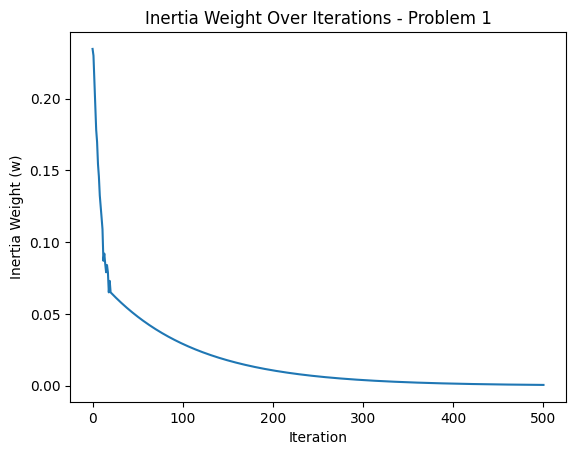

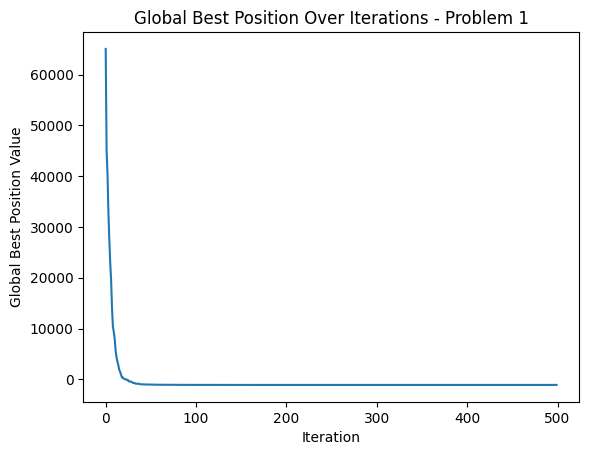




Problem 2 Best Cost: [-701.40191635 -701.43982695 -701.45879453 -701.45879453 -701.49246913
 -701.51633221 -701.53766544 -701.57036449 -701.57045315 -701.57045315
 -701.59481655 -701.61911364 -701.62975606 -701.6313734  -701.67244243
 -701.67244243 -701.67244243 -701.67244243 -701.69025797 -701.72091489
 -701.72091489 -701.72091489 -701.73196976 -701.73811702 -701.73888052
 -701.76005851 -701.76005851 -701.76005851 -701.76005851 -701.77079104
 -701.77796505 -701.81195218 -701.81195218 -701.83205979 -701.83205979
 -701.83205979 -701.83205979 -701.83240635 -701.83240635 -701.83524973
 -701.84421577 -701.84421577 -701.84421577 -701.86088388 -701.86088388
 -701.88303723 -701.88303723 -701.88439757 -701.89094198 -701.91025563
 -701.91025563 -701.91025563 -701.91025563 -701.91963014 -701.91963014
 -701.93962762 -701.93962762 -701.94654068 -701.96300651 -701.96300651
 -701.96300651 -701.96300651 -701.96801721 -701.97218075 -701.97218075
 -701.97218075 -701.97392878 -701.97392878 -701.98510

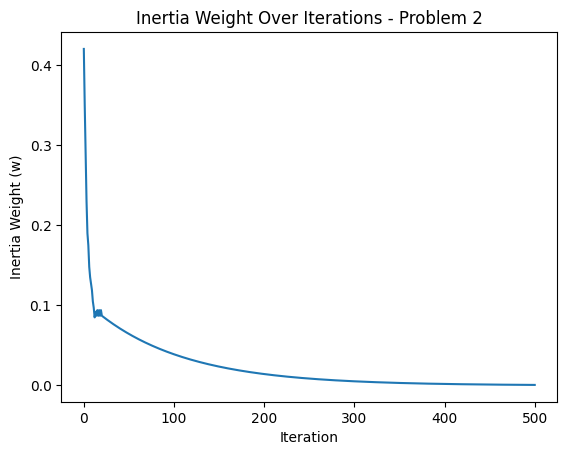

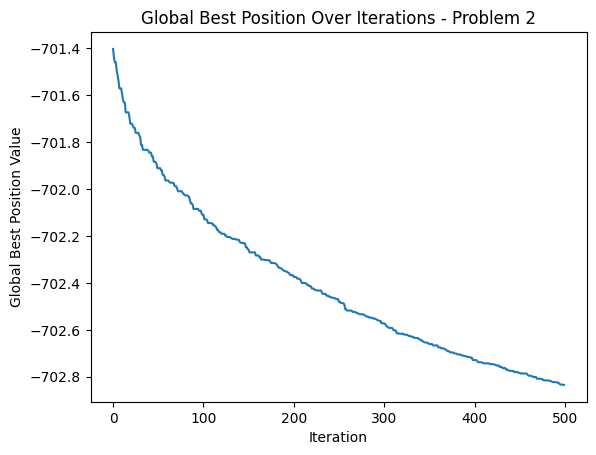




Problem 3 Best Cost: [ 2.92363912e+10  2.15505171e+10  1.39303932e+10  1.37817535e+10
  9.42550760e+09  6.64438396e+09  5.01436389e+09  4.33573420e+09
  4.32574093e+09  3.39952334e+09  2.91278630e+09  2.60410515e+09
  2.58317390e+09  2.04363724e+09  1.75881123e+09  1.53241009e+09
  1.42745053e+09  9.89074923e+08  8.82057357e+08  7.59166210e+08
  7.59166210e+08  7.20793043e+08  6.90113650e+08  5.50437162e+08
  5.50437162e+08  4.48410475e+08  3.85874218e+08  3.85874218e+08
  3.53090844e+08  3.00668274e+08  3.00668274e+08  2.84102918e+08
  2.84102918e+08  2.52595171e+08  2.48503111e+08  2.23324043e+08
  1.74532981e+08  1.63958581e+08  1.47364935e+08  1.23664160e+08
  1.23664160e+08  1.23664160e+08  1.19611655e+08  8.46530111e+07
  8.46530111e+07  8.46530111e+07  7.39895016e+07  7.39895016e+07
  7.36765711e+07  7.36765711e+07  6.28703119e+07  5.79987256e+07
  5.40073137e+07  4.46572830e+07  4.20880207e+07  3.37306268e+07
  3.37306268e+07  3.37306268e+07  3.37306268e+07  3.37306268e+07
 

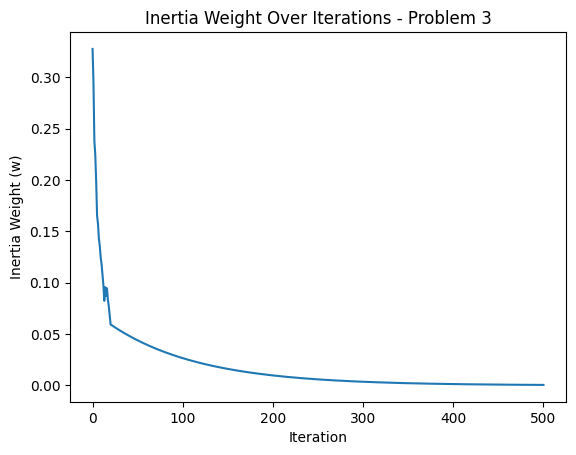

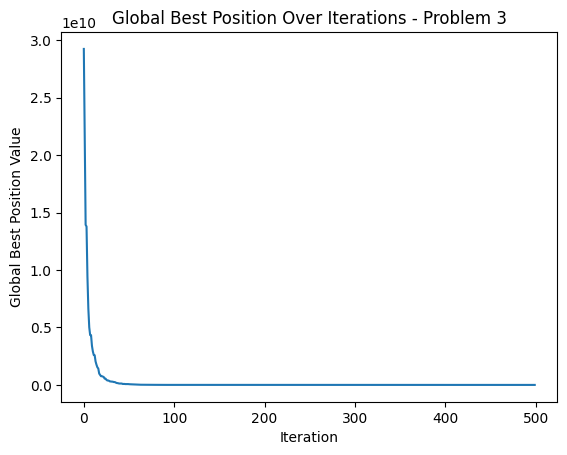




Problem 4 Best Cost: [ 3.12344035e+05  2.45832916e+05  2.04570491e+05  1.81474711e+05
  1.34362539e+05  8.04901194e+04  6.57237853e+04  5.66759991e+04
  4.92071065e+04  4.19905105e+04  3.10889741e+04  2.44285533e+04
  2.44285533e+04  1.65146121e+04  8.93765249e+03  8.93765249e+03
  7.38878567e+03  7.38878567e+03  7.38878567e+03  7.38878567e+03
  7.25906753e+03  5.36582557e+03  5.16533936e+03  4.38280097e+03
  3.57658804e+03  3.44264698e+03  3.44264698e+03  1.93562623e+03
  1.93562623e+03  1.85616440e+03  1.72116943e+03  1.72116943e+03
  1.54190976e+03  1.36392498e+03  1.36392498e+03  1.34079078e+03
  1.34079078e+03  8.61215228e+02  6.47906838e+02  4.27867932e+02
  4.27867932e+02  4.27867932e+02  3.83381007e+02  3.40511410e+02
  3.20225510e+02  3.20225510e+02  3.20225510e+02  3.04969490e+02
  3.04969490e+02  3.04969490e+02  1.98636542e+02  1.98636542e+02
  1.98636542e+02  1.81267942e+02  9.11999457e+01  4.51753503e+01
  4.51753503e+01  3.19030285e+01 -3.06358054e+01 -3.06358054e+01
 

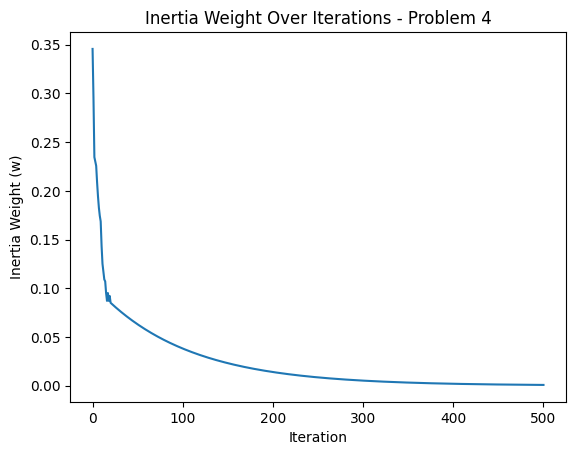

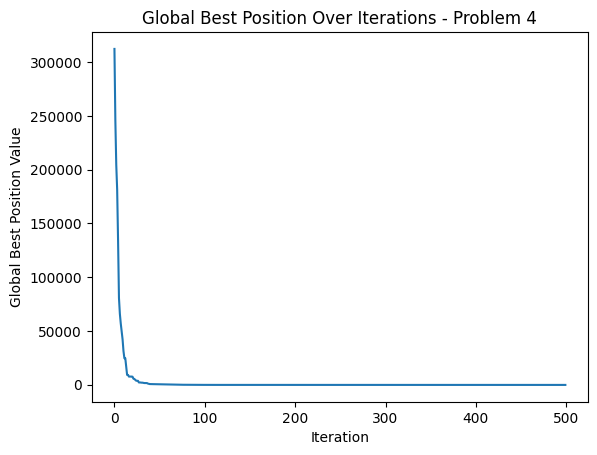




Problem 5 Best Cost: [-334.17157877 -334.20716819 -334.244572   -334.27595428 -334.36127603
 -334.42648648 -334.48666356 -334.50834202 -334.55169049 -334.58957981
 -334.64616549 -334.68928277 -334.69168982 -334.7072505  -334.75185046
 -334.75185046 -334.75185046 -334.7685332  -334.77323101 -334.82769642
 -334.82769642 -334.82769642 -334.82769642 -334.84390651 -334.86862126
 -334.86862126 -334.89062261 -334.89062261 -334.89062261 -334.89635087
 -334.90128761 -334.90304143 -334.90304143 -334.91845576 -334.94583978
 -334.94583978 -334.9607671  -334.9607671  -334.9607671  -334.96273893
 -334.97969397 -334.98161461 -335.0320114  -335.03528832 -335.06595259
 -335.07684208 -335.07684208 -335.07684208 -335.09766281 -335.09784652
 -335.10937831 -335.12245526 -335.13302484 -335.13730433 -335.13730433
 -335.14336645 -335.20945774 -335.20945774 -335.20945774 -335.20945774
 -335.20945774 -335.21450505 -335.21497474 -335.21497474 -335.22128005
 -335.22128005 -335.22385798 -335.24306935 -335.24306

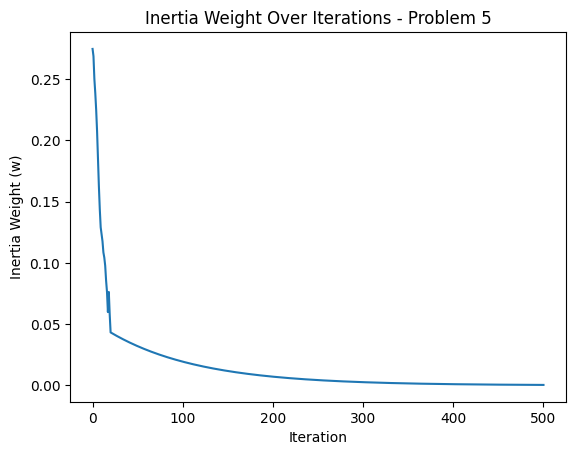

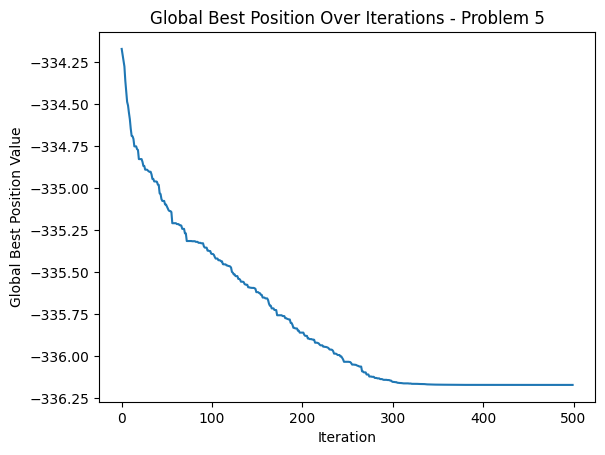




Problem 6 Best Cost: [-183.49768716 -183.54112608 -183.60677341 -183.65010089 -183.70430942
 -183.73325631 -183.77465789 -183.81647156 -183.83265954 -183.86246924
 -183.92191661 -183.92597257 -183.92597257 -183.95632993 -183.96523295
 -183.96523295 -183.9934015  -184.00951962 -184.05689987 -184.11194151
 -184.1361678  -184.1361678  -184.1361678  -184.1361678  -184.13811042
 -184.16452895 -184.16452895 -184.16452895 -184.18185867 -184.20940989
 -184.21295321 -184.24074986 -184.24074986 -184.2416303  -184.26012175
 -184.29707976 -184.29707976 -184.29707976 -184.31869186 -184.31869186
 -184.31869186 -184.31869186 -184.33073693 -184.34065793 -184.37025474
 -184.37757559 -184.38023689 -184.38595442 -184.40086128 -184.40086128
 -184.40086128 -184.41115356 -184.41115356 -184.41115356 -184.42056569
 -184.44516087 -184.44516087 -184.44516087 -184.44516087 -184.44516087
 -184.4582005  -184.46685826 -184.47198606 -184.49119205 -184.49119205
 -184.4918872  -184.4918872  -184.50472455 -184.50472

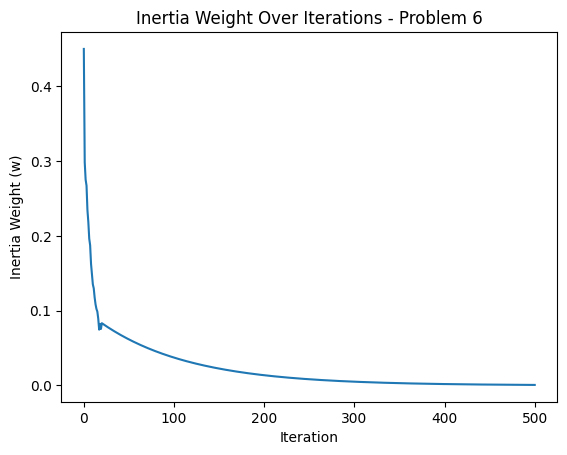

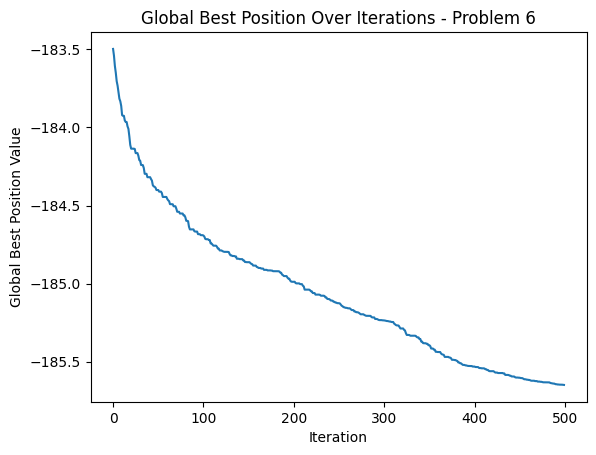




Problem 7 Best Cost: [62690.87093637 55545.83493536 42515.54940578 42515.54940578
 36760.10683305 36760.10683305 36567.41905056 36567.41905056
 33832.55254376 27720.96493711 24342.9867178  19804.49159103
 18039.14546494 18039.14546494 17543.89072783 17087.0968399
 17087.0968399  15276.47265561 13845.15859897 13845.15859897
 13845.15859897 13845.15859897 13845.15859897 11840.63984223
 11840.63984223 11840.63984223 11840.63984223 10643.62478733
 10643.62478733  9906.35721633  9434.08199968  9434.08199968
  9428.81999841  9428.81999841  8767.81032539  8767.81032539
  8767.81032539  8767.81032539  8767.81032539  8767.81032539
  8767.81032539  8767.81032539  8557.16961754  8488.10990117
  8488.10990117  8389.55102703  8389.55102703  7587.12511235
  7175.96828403  7175.96828403  7122.33149944  7122.33149944
  6993.76751617  6993.76751617  6993.76751617  6362.33446893
  6259.71258303  6259.71258303  5995.73442441  5995.73442441
  5995.73442441  5995.73442441  5457.15687714  5457.15687714
 

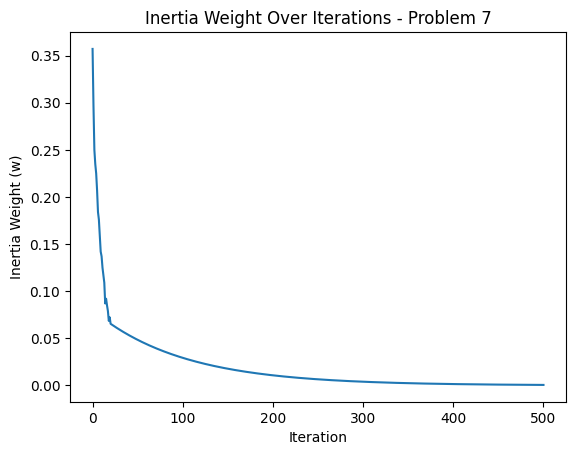

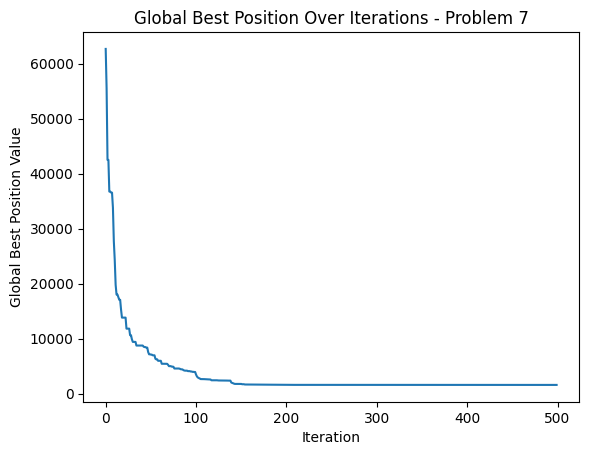




Problem 8 Best Cost: [49635.87467915 47853.14945829 36787.8265493  25906.47735436
 21174.84113173 21174.84113173 21174.84113173 20166.88617475
 19539.08852209 19539.08852209 19539.08852209 17258.67974614
 17021.31014877 17021.31014877 17021.31014877 16046.77750048
 16046.77750048 16046.77750048 16046.77750048 15766.84897538
 15766.84897538 15766.84897538 15766.84897538 15651.67804665
 14043.61566271 13218.41463001 13218.41463001 13218.41463001
 12417.82241795 11641.99699547 10252.7982844   8756.70638062
  7478.72662185  7478.72662185  7276.53848548  7136.58650059
  7030.76336514  5981.98686582  5765.27493125  4615.60398851
  3238.77430968  3238.77430968  3082.01118229  2836.50320022
  2698.78842963  2060.35914912  1364.06095537  1364.06095537
  1364.06095537  1364.06095537  1364.06095537  1364.06095537
  1364.06095537  1234.10646591   909.43314715   676.13614815
   211.42495927   211.42495927   211.42495927   211.42495927
   173.55454459   173.55454459   173.55454459   173.55454459


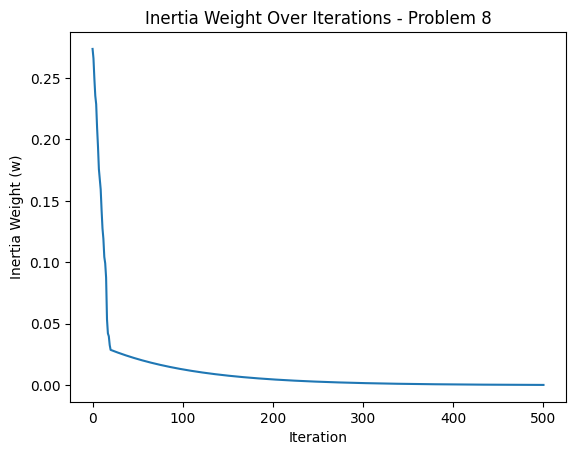

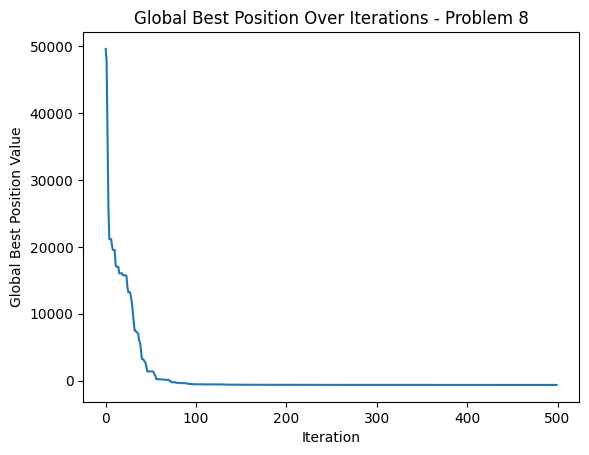




Problem 9 Best Cost: [242502.12986828  64737.87765114  64737.87765114  64737.87765114
  64737.87765114  64737.87765114  64737.87765114  64737.87765114
  64737.87765114  64737.87765114  64737.87765114  64737.87765114
  64737.87765114  64737.87765114  64737.87765114  64737.87765114
  64737.87765114  64737.87765114  37185.18024072  31786.33287305
  31786.33287305  31786.33287305  24293.42121794  24293.42121794
  24293.42121794  19425.25813676  19425.25813676  15598.00301831
  15598.00301831  15598.00301831  15598.00301831  15598.00301831
  15598.00301831  15598.00301831  15598.00301831  15598.00301831
  15598.00301831   7963.87056747   7963.87056747   7746.96846265
   7126.08733651   6767.81252821   6767.81252821   6767.81252821
   6767.81252821   5619.92692383   5619.92692383   5619.92692383
   4697.81842785   4697.81842785   4697.81842785   4697.81842785
   4697.81842785   4697.81842785   4551.27671503   4256.98763816
   4256.98763816   4114.54639385   4114.54639385   4114.54639385
 

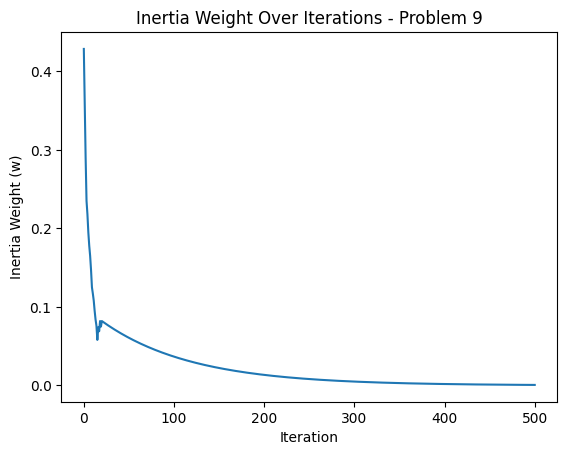

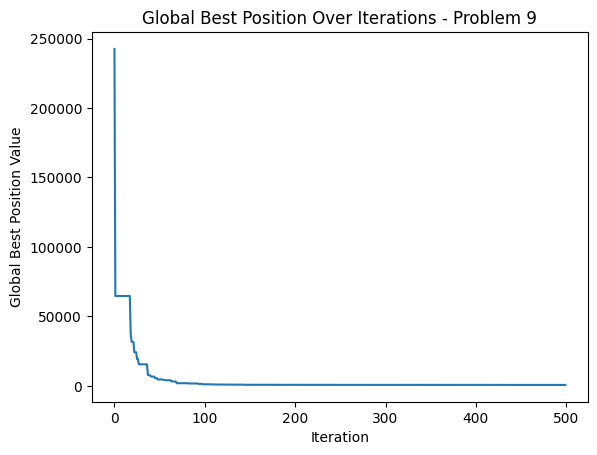




Problem 10 Best Cost: [73767.54034095 49058.9686614  36542.73156425 24818.41368657
 24818.41368657 24818.41368657 23018.25779264 20022.72105226
 15676.27238649 15676.27238649 15309.99339194 12042.41667239
 12042.41667239 12042.41667239 12042.41667239 10708.8992163
  9403.06221797  8371.35301322  8371.35301322  7557.59002914
  7203.11719499  6400.57338327  6400.57338327  6400.57338327
  6400.57338327  6068.53409175  6068.53409175  5951.24315079
  5417.53305215  5223.59020672  5223.59020672  5223.59020672
  5223.59020672  5223.59020672  5223.59020672  4957.57915893
  4806.19106354  4806.19106354  4596.93458141  4591.05511876
  4591.05511876  4456.68110145  4456.68110145  4456.68110145
  4332.09327086  4332.09327086  4332.09327086  3913.42347002
  3913.42347002  3861.22234165  3861.22234165  3861.22234165
  3861.22234165  3861.22234165  3478.81051841  3478.81051841
  3478.81051841  3296.62335004  3087.66512213  3087.66512213
  2945.26351604  2945.26351604  2945.26351604  2919.92146666


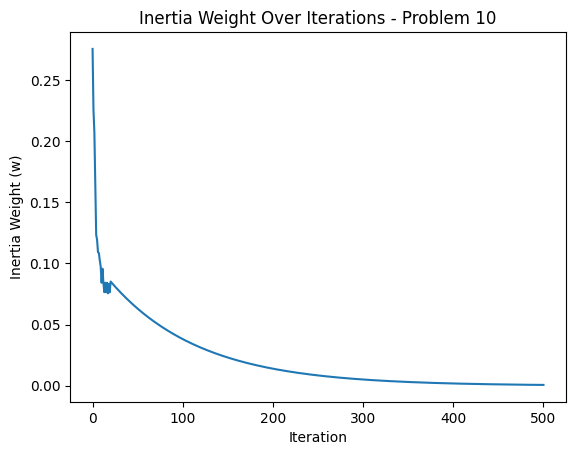

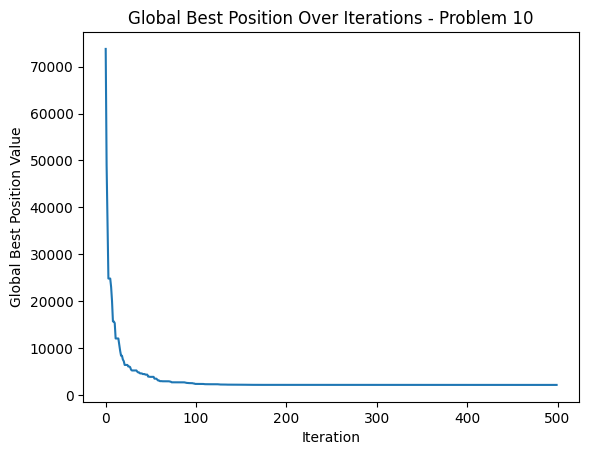




Problem 11 Best Cost: [ 6.49653549e+04  6.49653549e+04  4.01245226e+04  3.74309921e+04
  3.74309921e+04  2.90530604e+04  1.99165027e+04  1.99165027e+04
  1.99165027e+04  1.99165027e+04  1.99165027e+04  1.47792310e+04
  1.37341556e+04  1.15190308e+04  1.15190308e+04  1.12754704e+04
  1.11466659e+04  9.91607468e+03  9.91607468e+03  9.91607468e+03
  9.91607468e+03  8.59941622e+03  7.13296565e+03  7.13296565e+03
  7.13296565e+03  7.13296565e+03  7.13296565e+03  7.13296565e+03
  7.13296565e+03  6.64931065e+03  6.64931065e+03  6.47248722e+03
  6.47248722e+03  6.47248722e+03  6.47248722e+03  6.47248722e+03
  6.47248722e+03  6.47248722e+03  6.47248722e+03  6.36774484e+03
  6.36774484e+03  6.35367388e+03  6.35367388e+03  6.35367388e+03
  6.35367388e+03  6.35367388e+03  6.21822760e+03  6.21822760e+03
  6.21822760e+03  6.21822760e+03  6.21822760e+03  6.21822760e+03
  6.21822760e+03  6.21822760e+03  6.21822760e+03  6.21822760e+03
  6.21822760e+03  6.21822760e+03  6.04234587e+03  5.86320552e+03


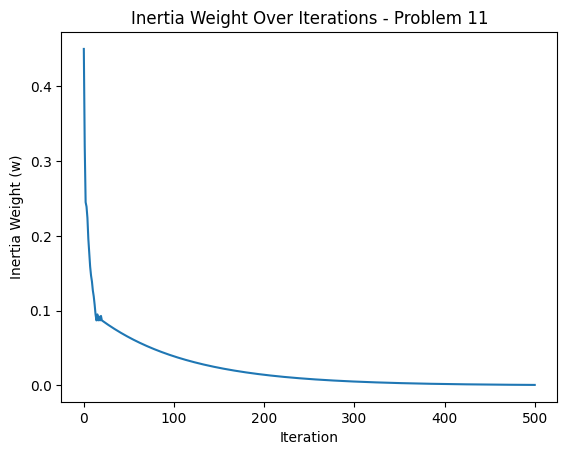

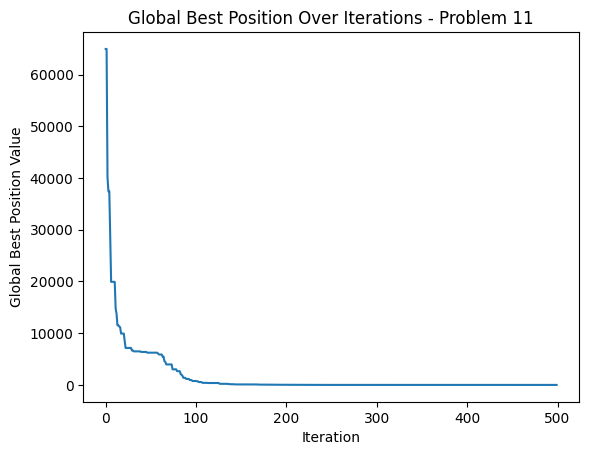




Problem 12 Best Cost: [66424.24751649 62401.09864887 54879.05873296 44908.34665018
 40286.64411766 30194.18145627 28158.57311361 28158.57311361
 25519.16925514 25519.16925514 25519.16925514 25519.16925514
 24526.27845079 21877.60694233 21593.57515751 21593.57515751
 18715.10632311 18715.10632311 18715.10632311 18715.10632311
 18715.10632311 17522.76359731 17522.76359731 17522.76359731
 17522.76359731 16629.81176414 16058.24215534 15189.99372892
 15189.99372892 15189.99372892 15189.99372892 15189.99372892
 15023.836441   15023.836441   14293.2449908  13199.04433352
 13199.04433352 13199.04433352 13199.04433352 13199.04433352
 13199.04433352 13199.04433352 12825.01102306 12825.01102306
 12825.01102306 12825.01102306 12531.07345307 12445.504815
 12445.504815   12445.504815   11491.65981211 11243.21201169
 11243.21201169 10903.63157158 10903.63157158 10903.63157158
 10903.63157158 10896.76916973 10896.76916973 10763.13175696
 10502.08227347 10502.08227347 10502.08227347 10502.08227347
 

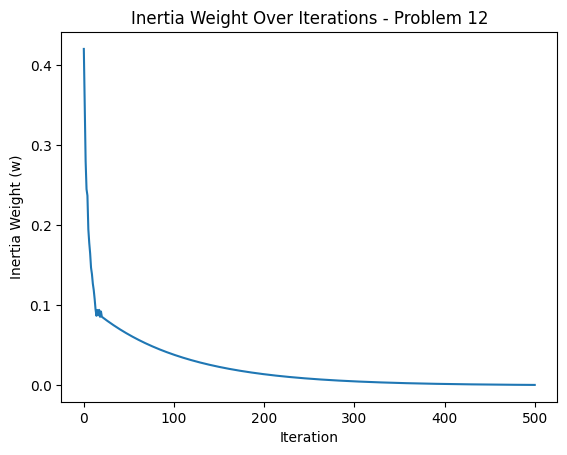

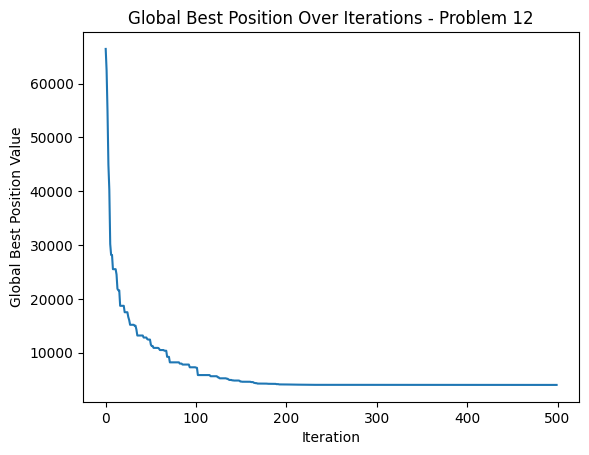




Problem 13 Best Cost: [151669.40064599 142134.18900405 142134.18900405 142134.18900405
 142134.18900405 142134.18900405 136635.27895704  97591.69714755
  97591.69714755  97591.69714755  97591.69714755  85276.45046526
  85276.45046526  85276.45046526  85276.45046526  85276.45046526
  85276.45046526  85276.45046526  85276.45046526  85276.45046526
  85276.45046526  85276.45046526  85276.45046526  85276.45046526
  74624.36847409  74624.36847409  74624.36847409  74624.36847409
  74624.36847409  74624.36847409  74624.36847409  74624.36847409
  74624.36847409  74624.36847409  74624.36847409  74624.36847409
  74624.36847409  74624.36847409  74624.36847409  74624.36847409
  74624.36847409  74624.36847409  74624.36847409  74624.36847409
  74624.36847409  74624.36847409  74624.36847409  74624.36847409
  74624.36847409  74624.36847409  74624.36847409  74624.36847409
  74624.36847409  74624.36847409  74624.36847409  74624.36847409
  74624.36847409  74624.36847409  63876.85845099  63876.85845099


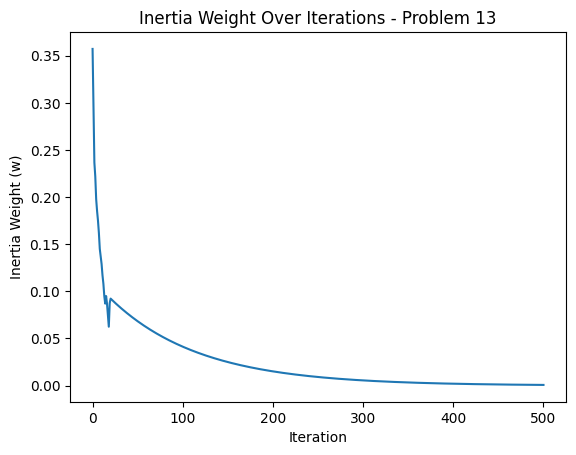

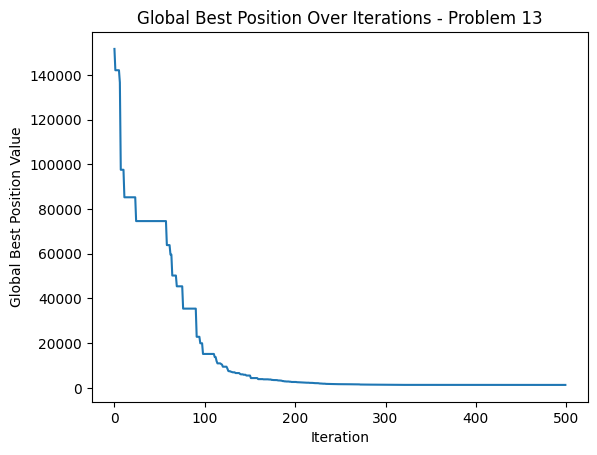




Problem 14 Best Cost: [39390.49951748 35359.0766558  30433.04384805 25735.78168356
 25735.78168356 25735.78168356 25735.78168356 25735.78168356
 25735.78168356 19621.65991736 19621.65991736 19621.65991736
 19621.65991736 19621.65991736 18264.49346868 18264.49346868
 18264.49346868 18264.49346868 18264.49346868 18264.49346868
 16867.8352745  16867.8352745  16867.8352745  16867.8352745
 16867.8352745  16867.8352745  16867.8352745  16867.8352745
 15891.21954282 15891.21954282 15891.21954282 15891.21954282
 15891.21954282 15891.21954282 15532.57559752 15532.57559752
 15532.57559752 15532.57559752 15141.13669052 15141.13669052
 15141.13669052 15141.13669052 14947.8844622  14947.8844622
 14767.25249824 14767.25249824 14767.25249824 14767.25249824
 14767.25249824 14767.25249824 14756.77949557 14756.77949557
 14756.77949557 14397.86145398 14342.1310648  14342.1310648
 14342.1310648  14313.12272392 14313.12272392 14297.10664027
 14060.03895778 14060.03895778 14060.03895778 14060.03895778
 13

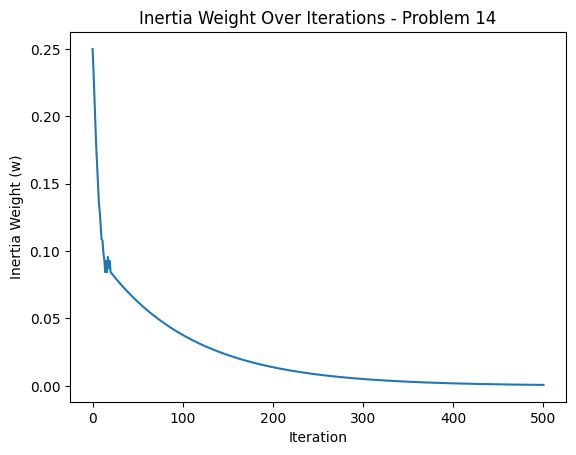

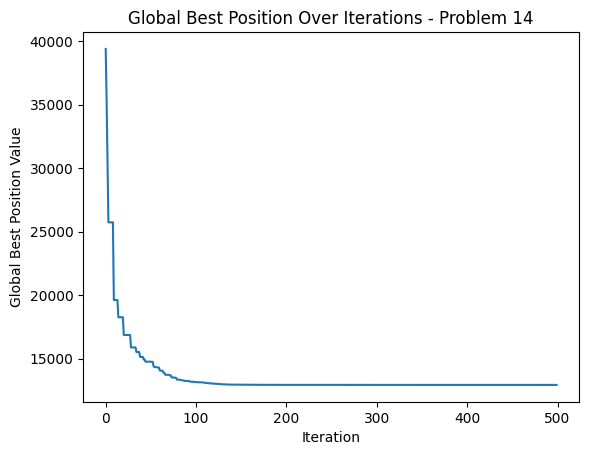




Problem 15 Best Cost: [-225.24395227 -225.24395227 -225.73909873 -225.73909873 -225.73909873
 -225.96327428 -226.82719764 -226.82719764 -226.82719764 -226.82719764
 -226.82719764 -226.82719764 -226.82719764 -226.82719764 -226.82719764
 -226.82719764 -226.82719764 -226.82719764 -226.82719764 -226.82719764
 -226.82719764 -226.82719764 -226.82719764 -226.82719764 -226.82719764
 -226.82719764 -226.82719764 -226.99563021 -227.18855786 -227.45169875
 -227.45169875 -227.73452473 -227.73452473 -227.73452473 -227.73452473
 -227.73452473 -227.73452473 -227.73452473 -227.73452473 -227.79899706
 -227.79899706 -227.82014987 -227.86166746 -227.86166746 -227.86166746
 -228.1054183  -228.1054183  -228.1054183  -228.1054183  -228.1054183
 -228.20734647 -228.20734647 -228.20734647 -228.20734647 -228.20734647
 -228.20734647 -228.20734647 -228.21267894 -228.24196357 -228.24196357
 -228.24196357 -228.24196357 -228.24196357 -228.25347169 -228.25347169
 -228.25419618 -228.25419618 -228.2691167  -228.26911

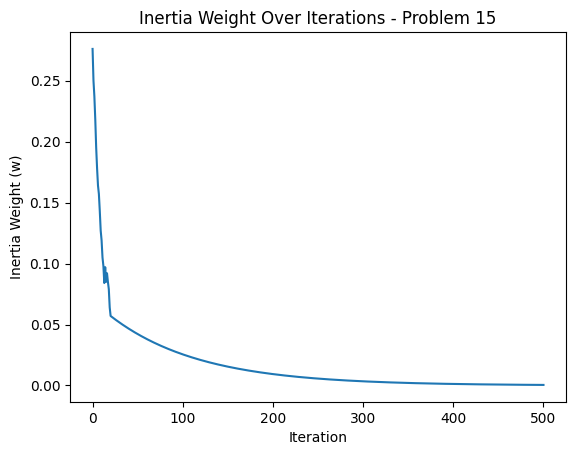

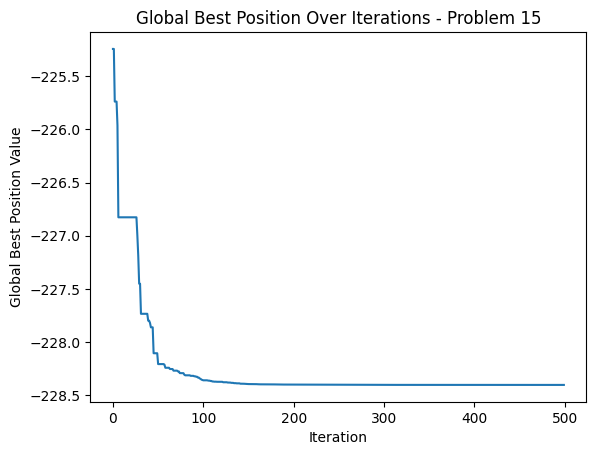




Problem 16 Best Cost: [56233.92846952 41348.87163162 28910.53321481 21934.00577153
 10270.50572794  6239.42848227  3755.84781404  3445.66401227
  2521.45005013  1317.46348078 -1084.11435803 -1084.11435803
 -1218.77284761 -2157.34144898 -2404.03777545 -2933.03288743
 -3159.83119126 -3341.99454085 -3488.48067523 -3490.29850404
 -3575.91391606 -3575.91391606 -3575.91391606 -3575.91391606
 -3678.43910213 -3693.92199779 -3743.5901032  -3853.01497822
 -3871.85184156 -3871.85184156 -3871.85184156 -3953.77121709
 -3960.97345646 -4045.60859504 -4045.60859504 -4088.12237674
 -4098.81002203 -4098.81002203 -4098.81002203 -4098.81002203
 -4132.77599369 -4132.77599369 -4144.02683956 -4144.02683956
 -4168.59199948 -4196.69040879 -4196.69040879 -4204.5276801
 -4231.1836419  -4231.1836419  -4231.1836419  -4231.1836419
 -4231.1836419  -4231.1836419  -4236.5961434  -4236.5961434
 -4236.5961434  -4236.5961434  -4277.57494204 -4277.57494204
 -4277.57494204 -4279.7123652  -4279.7123652  -4283.42384688
 -

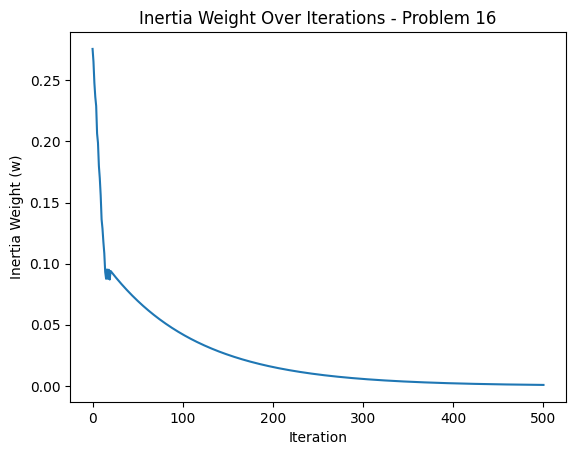

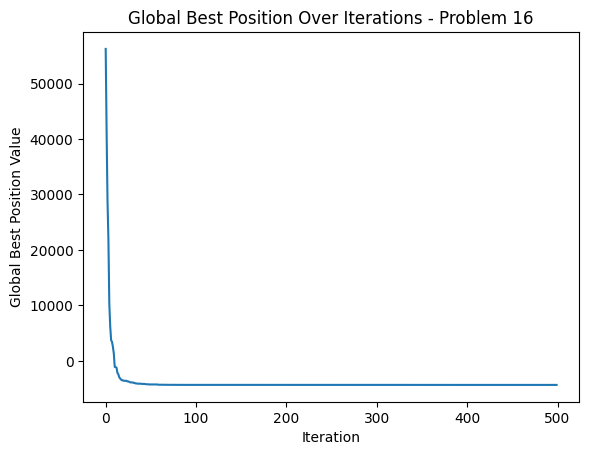




Problem 17 Best Cost: [ 2.19051524e+06  2.19051524e+06  1.78086782e+06  1.38160322e+06
  1.25957520e+06  8.59740905e+05  6.14845643e+05  5.16098428e+05
  4.31996039e+05  3.27418608e+05  2.40989700e+05  2.00537760e+05
  2.00537760e+05  1.43099456e+05  1.33675903e+05  1.21996636e+05
  1.13197794e+05  1.12096588e+05  9.10059382e+04  7.40606407e+04
  7.37971380e+04  7.22311139e+04  7.12805945e+04  6.57032617e+04
  5.28875647e+04  5.28875647e+04  5.16740484e+04  4.87541863e+04
  4.40205119e+04  4.15448894e+04  3.81469498e+04  3.81469498e+04
  3.74734177e+04  3.74734177e+04  2.94689029e+04  2.57143952e+04
  2.57143952e+04  2.57143952e+04  2.18253569e+04  2.01782812e+04
  2.01782812e+04  2.01782812e+04  2.01782812e+04  1.90776742e+04
  1.73427352e+04  1.68301777e+04  1.51062841e+04  1.33757965e+04
  1.33321732e+04  1.33321732e+04  1.31229447e+04  1.11302533e+04
  1.08936237e+04  1.03208401e+04  9.74146918e+03  9.74146918e+03
  9.29818478e+03  8.79089505e+03  8.79089505e+03  8.46419604e+03


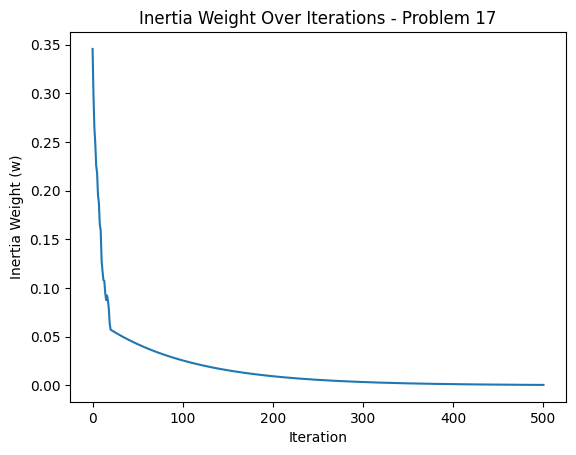

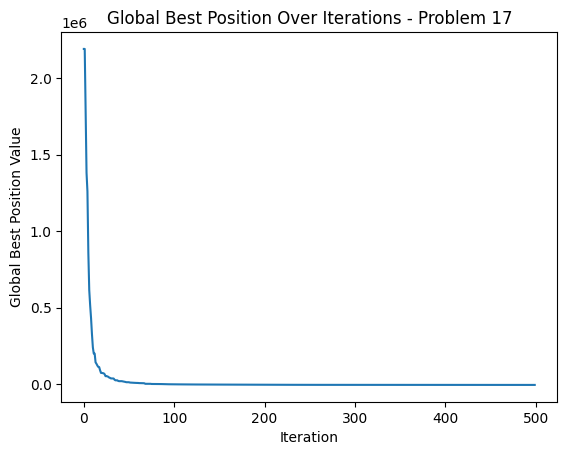




Problem 18 Best Cost: [53514.63956111 52194.18053955 21819.81497611 21819.81497611
 20463.32890296 13039.08190972 13039.08190972 13039.08190972
 13039.08190972 13039.08190972 13039.08190972 13039.08190972
 13039.08190972 13039.08190972 13039.08190972 13039.08190972
 13039.08190972 13039.08190972 13039.08190972 13039.08190972
 13039.08190972 13039.08190972 13039.08190972 13039.08190972
 13039.08190972 13039.08190972 13039.08190972 13039.08190972
 13039.08190972 13039.08190972 12829.21702004 12829.21702004
 12829.21702004 11799.70161501 11799.70161501  8746.65617907
  8746.65617907  8746.65617907  8746.65617907  8746.65617907
  8746.65617907  8746.65617907  8746.65617907  8746.65617907
  8746.65617907  8746.65617907  8746.65617907  8746.65617907
  8746.65617907  8746.65617907  8746.65617907  8746.65617907
  8496.27816474  8496.27816474  7778.46623476  7778.46623476
  7778.46623476  7778.46623476  7778.46623476  7778.46623476
  7778.46623476  7505.86665663  7505.86665663  7505.86665663

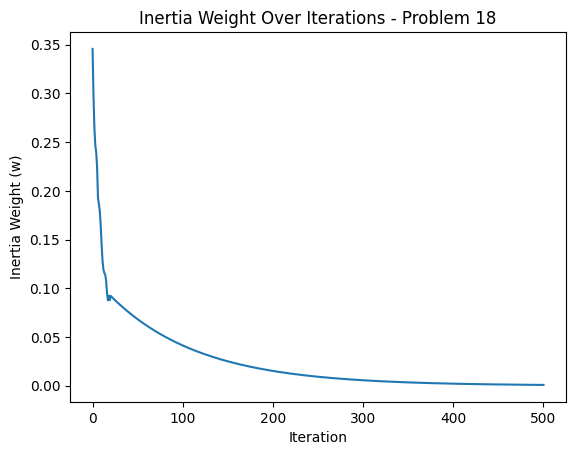

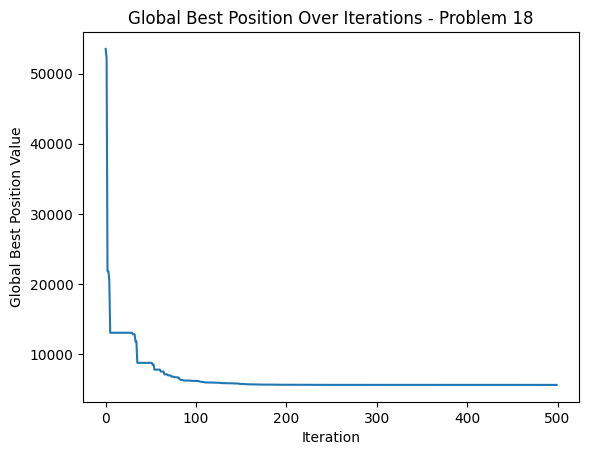




Problem 19 Best Cost: [55982.45920394 54207.2002201  51533.4841322  29634.74311561
 26374.0474797  26374.0474797  26374.0474797  26374.0474797
 26374.0474797  26374.0474797  26374.0474797  26374.0474797
 26374.0474797  26374.0474797  26374.0474797  26374.0474797
 22409.05737103 22409.05737103 22409.05737103 22409.05737103
 22409.05737103 22409.05737103 22409.05737103 22409.05737103
 22409.05737103 22409.05737103 22409.05737103 22409.05737103
 22409.05737103 22409.05737103 22409.05737103 22409.05737103
 21975.31266687 21975.31266687 21975.31266687 21975.31266687
 21975.31266687 21975.31266687 18550.11001291 18550.11001291
 16342.19625605 16342.19625605 16342.19625605 16342.19625605
 16342.19625605 16342.19625605 16342.19625605 16342.19625605
 16342.19625605 16342.19625605 16342.19625605 16342.19625605
 16342.19625605 16342.19625605 16342.19625605 16342.19625605
 16342.19625605 16342.19625605 16342.19625605 16342.19625605
 16342.19625605 16342.19625605 16342.19625605 16342.19625605
 1

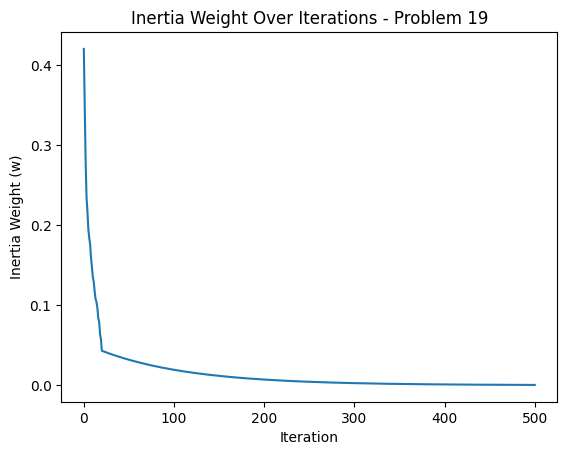

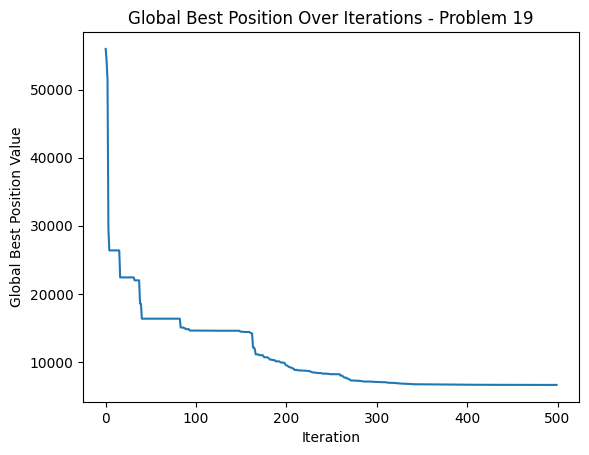




Problem 20 Best Cost: [-83.77391207 -83.77391207 -85.86254811 -85.86254811 -86.43367047
 -86.5135547  -86.59568231 -87.01513604 -87.37828823 -87.37828823
 -87.37828823 -87.4609452  -87.4609452  -87.65659827 -87.65659827
 -87.79372903 -87.79372903 -87.79372903 -87.79372903 -87.96727021
 -88.28040786 -88.36807087 -88.36807087 -88.36807087 -88.36807087
 -88.36807087 -88.36807087 -88.36807087 -88.44380035 -88.44380035
 -88.44380035 -88.44380035 -88.73405942 -88.73405942 -88.73405942
 -88.73405942 -88.73405942 -88.73405942 -88.73405942 -88.73405942
 -88.73405942 -88.73405942 -88.81293731 -88.81293731 -88.81293731
 -88.81293731 -88.81293731 -88.81293731 -88.81293731 -88.81293731
 -88.81293731 -88.81293731 -88.81293731 -88.81293731 -88.85294145
 -88.85294145 -88.85294145 -88.85294145 -88.85294145 -88.85294145
 -88.99791675 -88.99791675 -89.04420337 -89.04420337 -89.10875543
 -89.10875543 -89.13243698 -89.13243698 -89.13243698 -89.13243698
 -89.13243698 -89.15377428 -89.15377428 -89.1537742

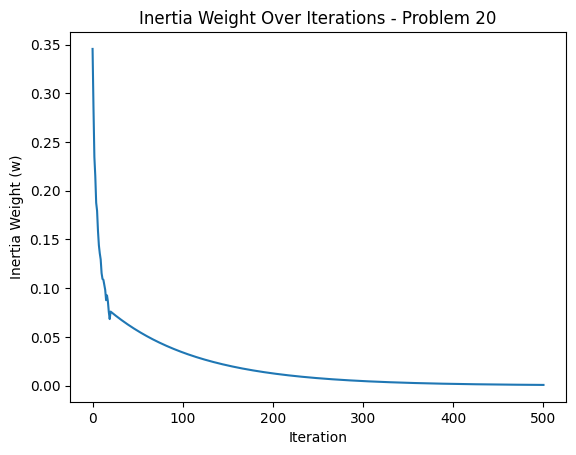

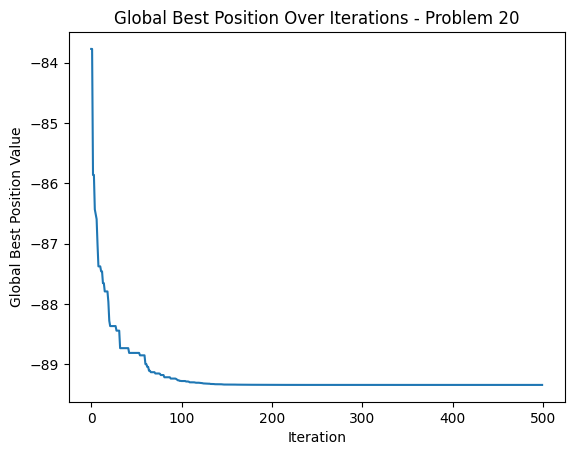




Problem 21 Best Cost: [161.04037385 104.17482979  57.91797803  23.4647932   15.79027819
   3.16200873   3.16200873   0.5236584   -1.61009015  -2.38233426
 -11.90940975 -11.90940975 -11.90940975 -11.90940975 -13.21263832
 -16.67051718 -18.94142877 -20.04779477 -20.04779477 -20.04779477
 -20.80522675 -22.45120394 -22.45120394 -22.45120394 -22.45120394
 -22.45120394 -23.57960006 -24.58721017 -24.58721017 -24.58732112
 -24.58732112 -25.42803523 -25.42803523 -25.42803523 -25.42803523
 -25.42803523 -25.71416572 -27.23462566 -27.23462566 -27.56062779
 -27.56062779 -28.03407879 -28.03407879 -28.95700882 -28.95700882
 -28.95700882 -30.06795588 -32.29868798 -32.92069932 -33.31686082
 -33.31686082 -33.31686082 -33.31686082 -33.31807856 -33.91604448
 -33.91604448 -33.91604448 -34.73663176 -34.73663176 -34.73663176
 -34.73663176 -35.27431497 -35.27431497 -35.27431497 -35.27431497
 -35.27431497 -35.27431497 -35.27431497 -35.58172367 -35.58172367
 -36.04997148 -36.04997148 -36.04997148 -36.0499714

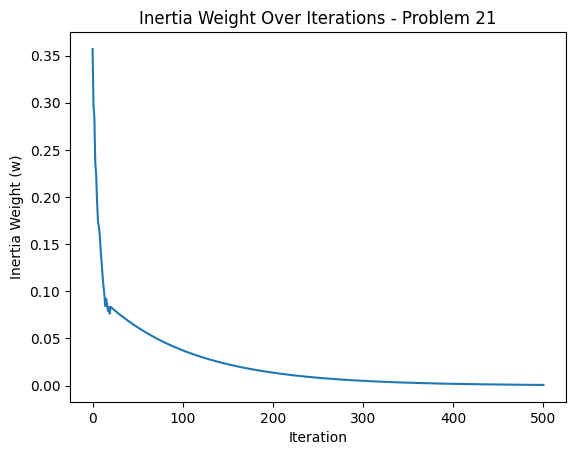

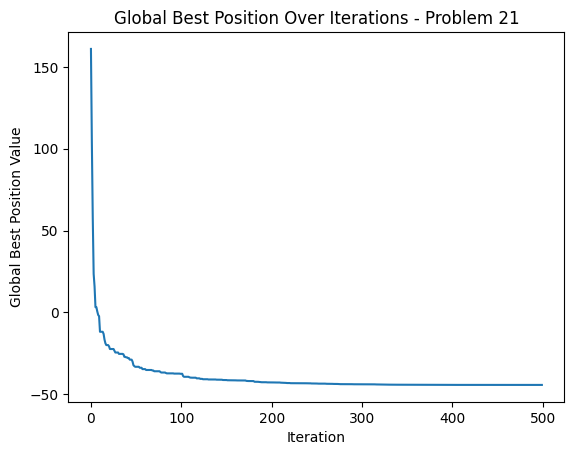




Problem 22 Best Cost: [252572.22473072 223072.55831103 223072.55831103 200788.98283207
 200788.98283207 200788.98283207 200788.98283207 200788.98283207
 200788.98283207 200788.98283207 200788.98283207 200788.98283207
 200788.98283207 200788.98283207 200788.98283207 200788.98283207
 200788.98283207 200788.98283207 200788.98283207 200788.98283207
 195267.28606516 195267.28606516 195267.28606516 195267.28606516
 195267.28606516 195267.28606516 195267.28606516 157729.07387474
 157729.07387474 157729.07387474 157729.07387474 157729.07387474
 157729.07387474 157729.07387474 157729.07387474 157729.07387474
 157729.07387474 157729.07387474 157729.07387474 157729.07387474
 157729.07387474 157729.07387474 157729.07387474 135142.78706753
 135142.78706753 135142.78706753 135142.78706753 135142.78706753
 135142.78706753 135142.78706753 135142.78706753 135142.78706753
 135142.78706753 135142.78706753 135142.78706753 135142.78706753
 135142.78706753 135142.78706753 135142.78706753 135142.78706753


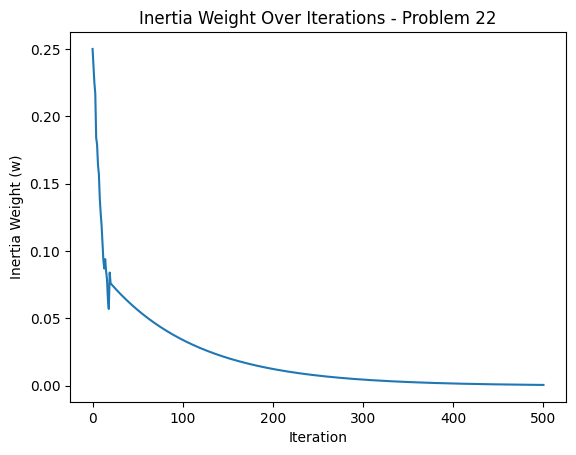

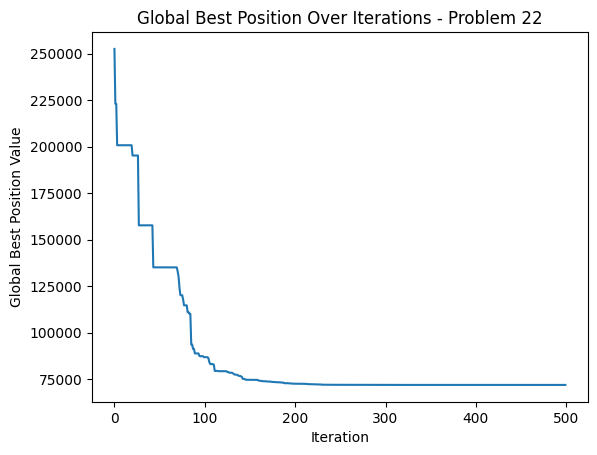




Problem 23 Best Cost: [-11.51154046 -31.56004296 -31.56004296 -31.56004296 -41.52527782
 -41.52527782 -41.52527782 -41.52527782 -41.52527782 -41.52527782
 -41.52527782 -41.52527782 -41.52527782 -41.52527782 -41.52527782
 -41.52527782 -41.52527782 -41.52527782 -41.52527782 -41.52527782
 -41.52527782 -41.52527782 -41.52527782 -41.52527782 -41.52527782
 -41.52527782 -41.52527782 -41.52527782 -41.52527782 -41.52527782
 -42.14426378 -46.46547415 -46.46547415 -46.46547415 -46.46547415
 -46.46547415 -46.46547415 -46.46547415 -46.46547415 -46.63218447
 -46.63218447 -46.63218447 -46.63218447 -46.63446877 -46.87298037
 -46.87298037 -47.31537862 -48.18684797 -48.18684797 -48.24025555
 -48.47892459 -48.88401407 -48.88401407 -49.46409113 -49.46409113
 -49.67261462 -49.67261462 -49.79517324 -49.79517324 -49.79517324
 -49.79517324 -50.18220213 -50.18220213 -50.3844779  -50.69281029
 -51.24347395 -51.47817164 -52.16740861 -52.16740861 -52.32244075
 -52.32244075 -52.32244075 -52.32244075 -52.8541079

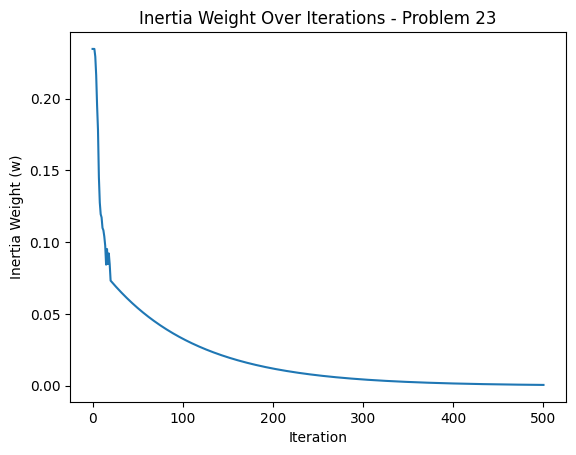

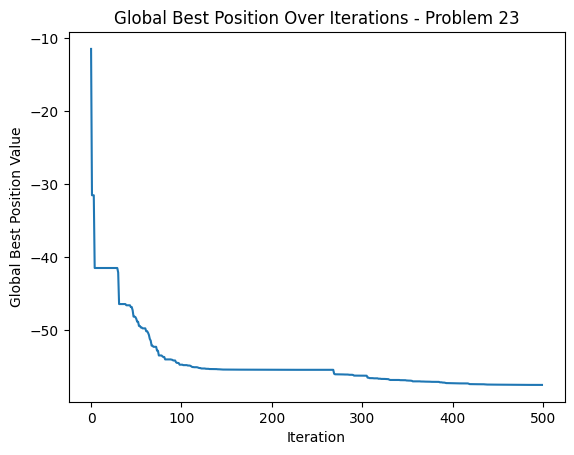




Problem 24 Best Cost: [118.2346287  114.49830099 100.17721543 100.17721543  83.94138406
  72.7750393   54.43047484  49.50412815  39.74292344  23.36424596
  20.97268283  17.51758866  15.0692455   -2.6727531   -2.6727531
  -2.6727531   -2.6727531   -2.6727531   -7.82241672 -11.14182129
 -11.14182129 -11.14182129 -11.14182129 -11.14182129 -17.59349942
 -17.59349942 -18.24065997 -18.69599777 -18.69599777 -18.69599777
 -19.02721063 -19.02721063 -19.02721063 -19.02721063 -19.02721063
 -19.02721063 -19.02721063 -19.02721063 -19.02721063 -19.02721063
 -19.02721063 -19.02721063 -21.01879246 -21.01879246 -21.01879246
 -21.01879246 -21.01879246 -21.01879246 -21.01879246 -21.01879246
 -21.01879246 -21.71518445 -21.71518445 -21.71518445 -22.57958125
 -22.57958125 -22.57958125 -22.57958125 -22.9893411  -22.9893411
 -22.9893411  -23.62878656 -23.62878656 -23.62878656 -23.62878656
 -26.42504952 -26.42504952 -26.42504952 -26.42504952 -26.42504952
 -26.42504952 -26.42504952 -26.42504952 -26.42504952 

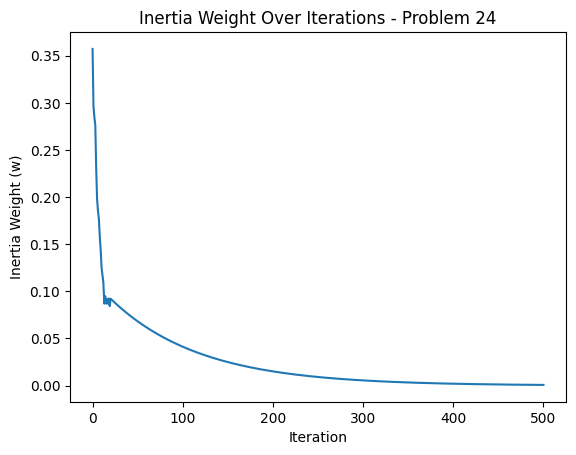

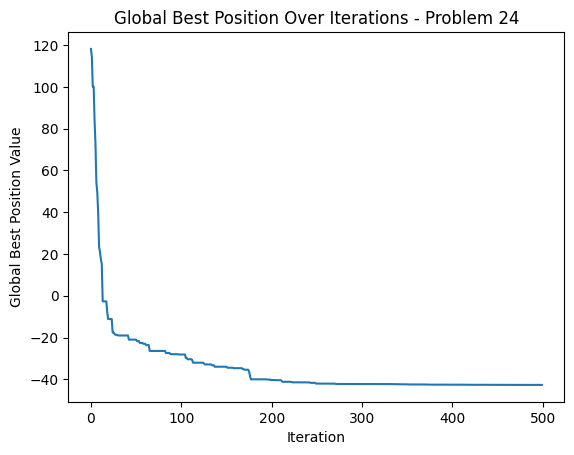

In [22]:
for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]

    print("\n\n\nProblem", curr, "Best Cost:", problem_results['BestCost'])
    print("Problem", curr, "Best Position:", problem_results['BestPosition'])

    plt.plot(problem_results['w_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Inertia Weight (w)')
    plt.title(f'Inertia Weight Over Iterations - Problem {curr}')
    plt.show()

    plt.plot(problem_results['g_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Global Best Position Value')
    plt.title(f'Global Best Position Over Iterations - Problem {curr}')
    plt.show()

In [23]:
print('nice')

nice


In [24]:
print('almost complete')

almost complete


In [25]:
print("Don't disconnect runtime")

Don't disconnect runtime


In [27]:
print('ok')

ok
